# Install Dependencies

In [1]:
%%capture
%pip install torch_geometric torch pandas wandb

In [2]:
import os
import shutil

# Create a directory in your Google Drive
workdir = os.getcwd() + ("/data")

# # Remove and recreate directory
# if os.path.exists(workdir):
#     shutil.rmtree(workdir)
# os.makedirs(workdir)

# Dataset Construction

## Download Dataset

In [3]:
# Clone the repository to download the S&P500 stock prices, precomputed correlation matrcies,
# along with trained model weights for ease of evaluation
# !git clone https://github.com/AlienKevin/sp500.git

# import shutil
# import os

# repo_name = "sp500"
# for file_name in os.listdir(repo_name):
#     shutil.move(os.path.join(repo_name, file_name), workdir)

# # Remove the cloned repository folder
# shutil.rmtree(repo_name)

## Exploratory Data Analysis Shows Superiority of Mutual Information in Capturing Interstock Relationships

In [4]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np

# Plot the 3 most correlated stocks to the target_stock based on corr_name with scope corr_scope
def plot_most_correlated_stocks(target_stock, corr_name, corr_scope):
    df = pd.read_csv(f'{workdir}/sp500.csv')
    df['Date'] = pd.to_datetime(df['Date'])
    df = df.set_index('Date')

    target_index = df.columns.get_loc(target_stock)

    corr = np.loadtxt(f'{workdir}/{corr_name}/{corr_scope}.csv', delimiter=',')

    top_3_correlated_indices = corr[target_index].argsort()[-4:][::-1]
    top_3_correlated_stocks = df.columns[top_3_correlated_indices]

    plt.clf()
    plt.figure(figsize=(12, 6))
    plt.style.use('default')

    for stock in top_3_correlated_stocks:
        if corr_scope.startswith('global'):
            # Plot the entire duration of the dataset for global correlations
            plt.plot(df.index, df[stock], label=stock)
        else:
            # Only plot the time window corresponding to the local correlations
            num_days_in_quarter = 64
            quarter_index = int(corr_scope.split('_')[-1])
            quarter_start_index = quarter_index * num_days_in_quarter
            quarter_end_index = (quarter_index + 1) * num_days_in_quarter
            print('Quarter Start date', df.index[quarter_start_index])
            print('Quarter End date', df.index[quarter_end_index])
            quarter_df = df.iloc[quarter_start_index:quarter_end_index]
            plt.plot(quarter_df.index, quarter_df[stock], label=stock)

    plt.title(f"Top 3 Correlated Stocks with {top_3_correlated_stocks[0]} using {'Global' if corr_scope.startswith('global') else 'Local'} {'Pearson' if corr_name == 'pcc' else 'Mutual Information'}: {', '.join(top_3_correlated_stocks[1:])}")
    plt.xlabel("Date")
    plt.ylabel("Price")
    plt.legend()
    plt.grid(True)
    plt.show()


## Global Mutual Information Captures Shared Trends Well

<Figure size 640x480 with 0 Axes>

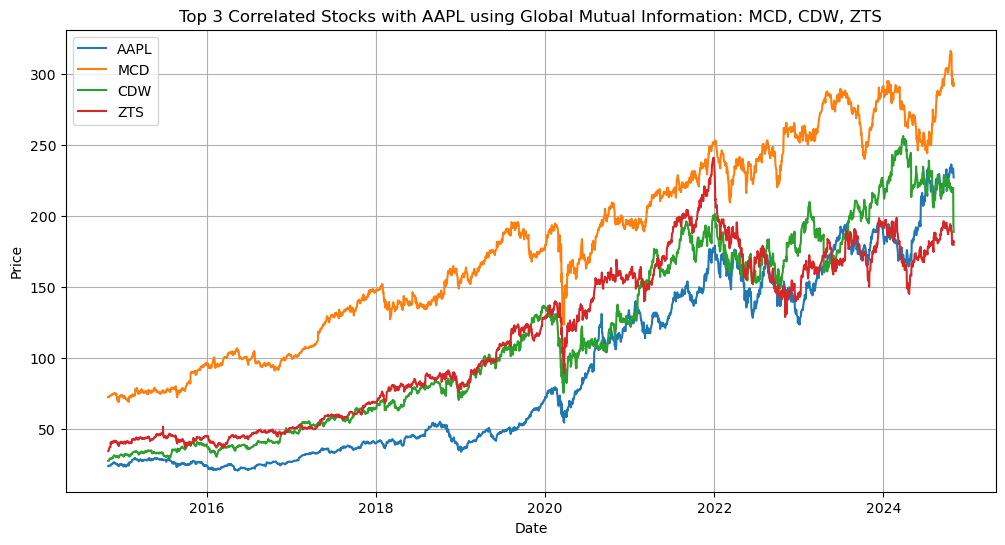

In [5]:
plot_most_correlated_stocks('AAPL', 'mi', 'global_corr')

## Global Pearson Struggles with Nonlinearity in the Market

<Figure size 640x480 with 0 Axes>

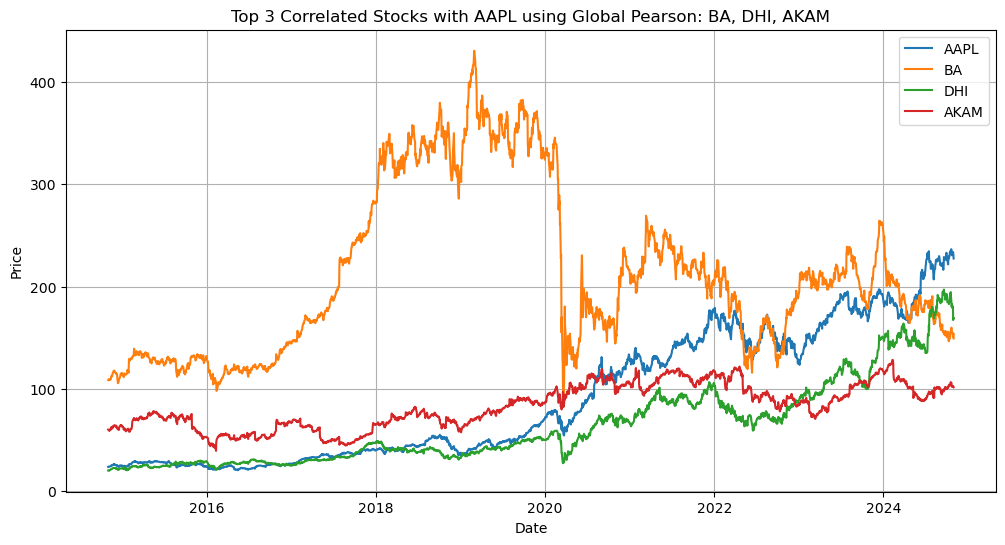

In [6]:
plot_most_correlated_stocks('AAPL', 'pcc', 'global_corr')

## Mutual Information and Pearson Perform Similarly Well on a Local Scope (the Length of 1 Fiscal Quarter)

Quarter Start date 2024-07-03 00:00:00+00:00
Quarter End date 2024-10-03 00:00:00+00:00
Quarter Start date 2024-07-03 00:00:00+00:00
Quarter End date 2024-10-03 00:00:00+00:00
Quarter Start date 2024-07-03 00:00:00+00:00
Quarter End date 2024-10-03 00:00:00+00:00
Quarter Start date 2024-07-03 00:00:00+00:00
Quarter End date 2024-10-03 00:00:00+00:00


<Figure size 640x480 with 0 Axes>

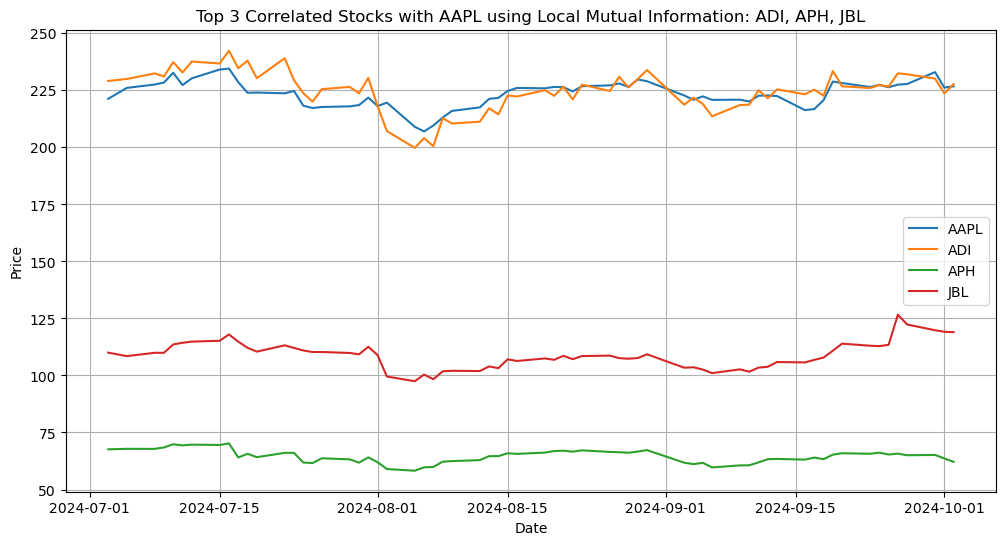

In [7]:
plot_most_correlated_stocks('AAPL', 'mi', 'local_corr_38')

Quarter Start date 2024-07-03 00:00:00+00:00
Quarter End date 2024-10-03 00:00:00+00:00
Quarter Start date 2024-07-03 00:00:00+00:00
Quarter End date 2024-10-03 00:00:00+00:00
Quarter Start date 2024-07-03 00:00:00+00:00
Quarter End date 2024-10-03 00:00:00+00:00
Quarter Start date 2024-07-03 00:00:00+00:00
Quarter End date 2024-10-03 00:00:00+00:00


<Figure size 640x480 with 0 Axes>

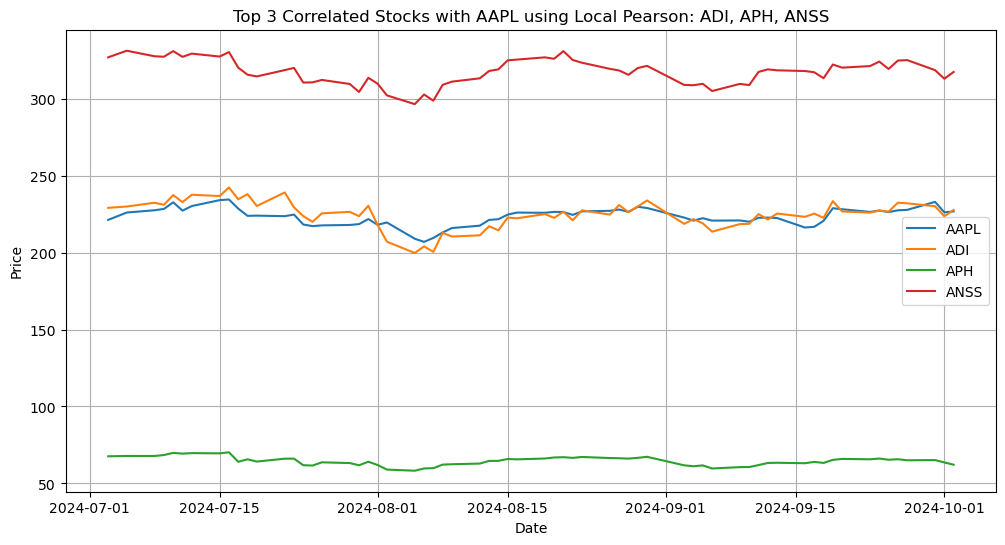

In [8]:
plot_most_correlated_stocks('AAPL', 'pcc', 'local_corr_38')

## Construct Temporal PyG Dataset

In [9]:
# Copied from PyG temporal rather than imported because the library has dependency issues with PyG
# https://pytorch-geometric-temporal.readthedocs.io/en/latest/_modules/torch_geometric_temporal/signal/dynamic_graph_temporal_signal.html

from typing import Sequence, Union
import numpy as np
import torch
from torch_geometric.data import Data


Edge_Indices = Sequence[Union[np.ndarray, None]]
Edge_Weights = Sequence[Union[np.ndarray, None]]
Node_Features = Sequence[Union[np.ndarray, None]]
Targets = Sequence[Union[np.ndarray, None]]
Additional_Features = Sequence[np.ndarray]

class DynamicGraphTemporalSignal(object):
    r"""A data iterator object to contain a dynamic graph with a
    changing edge set and weights . The feature set and node labels
    (target) are also dynamic. The iterator returns a single discrete temporal
    snapshot for a time period (e.g. day or week). This single snapshot is a
    Pytorch Geometric Data object. Between two temporal snapshots the edges,
    edge weights, target matrices and optionally passed attributes might change.

    Args:
        edge_indices (Sequence of Numpy arrays): Sequence of edge index tensors.
        edge_weights (Sequence of Numpy arrays): Sequence of edge weight tensors.
        features (Sequence of Numpy arrays): Sequence of node feature tensors.
        targets (Sequence of Numpy arrays): Sequence of node label (target) tensors.
        **kwargs (optional Sequence of Numpy arrays): Sequence of additional attributes.
    """

    def __init__(
        self,
        edge_indices: Edge_Indices,
        edge_weights: Edge_Weights,
        features: Node_Features,
        targets: Targets,
        **kwargs: Additional_Features
    ):
        self.edge_indices = edge_indices
        self.edge_weights = edge_weights
        self.features = features
        self.targets = targets
        self.additional_feature_keys = []
        for key, value in kwargs.items():
            setattr(self, key, value)
            self.additional_feature_keys.append(key)
        self._check_temporal_consistency()
        self._set_snapshot_count()

    def _check_temporal_consistency(self):
        assert len(self.features) == len(
            self.targets
        ), "Temporal dimension inconsistency."
        assert len(self.edge_indices) == len(
            self.edge_weights
        ), "Temporal dimension inconsistency."
        assert len(self.features) == len(
            self.edge_weights
        ), "Temporal dimension inconsistency."
        for key in self.additional_feature_keys:
            assert len(self.targets) == len(
                getattr(self, key)
            ), "Temporal dimension inconsistency."

    def _set_snapshot_count(self):
        self.snapshot_count = len(self.features)

    def _get_edge_index(self, time_index: int):
        if self.edge_indices[time_index] is None:
            return self.edge_indices[time_index]
        else:
            return torch.LongTensor(self.edge_indices[time_index])

    def _get_edge_weight(self, time_index: int):
        if self.edge_weights[time_index] is None:
            return self.edge_weights[time_index]
        else:
            return torch.FloatTensor(self.edge_weights[time_index])

    def _get_features(self, time_index: int):
        if self.features[time_index] is None:
            return self.features[time_index]
        else:
            return torch.FloatTensor(self.features[time_index])

    def _get_target(self, time_index: int):
        if self.targets[time_index] is None:
            return self.targets[time_index]
        else:
            if self.targets[time_index].dtype.kind == "i":
                return torch.LongTensor(self.targets[time_index])
            elif self.targets[time_index].dtype.kind == "f":
                return torch.FloatTensor(self.targets[time_index])

    def _get_additional_feature(self, time_index: int, feature_key: str):
        feature = getattr(self, feature_key)[time_index]
        if feature.dtype.kind == "i":
            return torch.LongTensor(feature)
        elif feature.dtype.kind == "f":
            return torch.FloatTensor(feature)

    def _get_additional_features(self, time_index: int):
        additional_features = {
            key: self._get_additional_feature(time_index, key)
            for key in self.additional_feature_keys
        }
        return additional_features

    def __getitem__(self, time_index: Union[int, slice]):
        if isinstance(time_index, slice):
            snapshot = DynamicGraphTemporalSignal(
                self.edge_indices[time_index],
                self.edge_weights[time_index],
                self.features[time_index],
                self.targets[time_index],
                **{key: getattr(self, key)[time_index] for key in self.additional_feature_keys}
            )
        else:
            x = self._get_features(time_index)
            edge_index = self._get_edge_index(time_index)
            edge_weight = self._get_edge_weight(time_index)
            y = self._get_target(time_index)
            additional_features = self._get_additional_features(time_index)

            snapshot = Data(x=x, edge_index=edge_index, edge_attr=edge_weight,
                            y=y, **additional_features)
        return snapshot

    def __next__(self):
        if self.t < len(self.features):
            snapshot = self[self.t]
            self.t = self.t + 1
            return snapshot
        else:
            self.t = 0
            raise StopIteration

    def __iter__(self):
        self.t = 0
        return self

/opt/anaconda3/envs/data/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [10]:
# Copied from PyG temporal rather than imported because the library has dependency issues with PyG
# https://pytorch-geometric-temporal.readthedocs.io/en/latest/_modules/torch_geometric_temporal/signal/static_graph_temporal_signal.html#StaticGraphTemporalSignal
import torch
import numpy as np
from typing import Sequence, Union
from torch_geometric.data import Data


Edge_Index = Union[np.ndarray, None]
Edge_Weight = Union[np.ndarray, None]
Node_Features = Sequence[Union[np.ndarray, None]]
Targets = Sequence[Union[np.ndarray, None]]
Additional_Features = Sequence[np.ndarray]

class StaticGraphTemporalSignal(object):
    r"""A data iterator object to contain a static graph with a dynamically
    changing constant time difference temporal feature set (multiple signals).
    The node labels (target) are also temporal. The iterator returns a single
    constant time difference temporal snapshot for a time period (e.g. day or week).
    This single temporal snapshot is a Pytorch Geometric Data object. Between two
    temporal snapshots the features and optionally passed attributes might change.
    However, the underlying graph is the same.

    Args:
        edge_index (Numpy array): Index tensor of edges.
        edge_weight (Numpy array): Edge weight tensor.
        features (Sequence of Numpy arrays): Sequence of node feature tensors.
        targets (Sequence of Numpy arrays): Sequence of node label (target) tensors.
        **kwargs (optional Sequence of Numpy arrays): Sequence of additional attributes.
    """

    def __init__(
        self,
        edge_index: Edge_Index,
        edge_weight: Edge_Weight,
        features: Node_Features,
        targets: Targets,
        **kwargs: Additional_Features
    ):
        self.edge_index = edge_index
        self.edge_weight = edge_weight
        self.features = features
        self.targets = targets
        self.additional_feature_keys = []
        for key, value in kwargs.items():
            setattr(self, key, value)
            self.additional_feature_keys.append(key)
        self._check_temporal_consistency()
        self._set_snapshot_count()

    def _check_temporal_consistency(self):
        assert len(self.features) == len(
            self.targets
        ), "Temporal dimension inconsistency."
        for key in self.additional_feature_keys:
            assert len(self.targets) == len(
                getattr(self, key)
            ), "Temporal dimension inconsistency."

    def _set_snapshot_count(self):
        self.snapshot_count = len(self.features)

    def _get_edge_index(self):
        if self.edge_index is None:
            return self.edge_index
        else:
            return torch.LongTensor(self.edge_index)

    def _get_edge_weight(self):
        if self.edge_weight is None:
            return self.edge_weight
        else:
            return torch.FloatTensor(self.edge_weight)

    def _get_features(self, time_index: int):
        if self.features[time_index] is None:
            return self.features[time_index]
        else:
            return torch.FloatTensor(self.features[time_index])

    def _get_target(self, time_index: int):
        if self.targets[time_index] is None:
            return self.targets[time_index]
        else:
            if self.targets[time_index].dtype.kind == "i":
                return torch.LongTensor(self.targets[time_index])
            elif self.targets[time_index].dtype.kind == "f":
                return torch.FloatTensor(self.targets[time_index])

    def _get_additional_feature(self, time_index: int, feature_key: str):
        feature = getattr(self, feature_key)[time_index]
        if feature.dtype.kind == "i":
            return torch.LongTensor(feature)
        elif feature.dtype.kind == "f":
            return torch.FloatTensor(feature)

    def _get_additional_features(self, time_index: int):
        additional_features = {
            key: self._get_additional_feature(time_index, key)
            for key in self.additional_feature_keys
        }
        return additional_features

    def __getitem__(self, time_index: Union[int, slice]):
        if isinstance(time_index, slice):
            snapshot = StaticGraphTemporalSignal(
                self.edge_index,
                self.edge_weight,
                self.features[time_index],
                self.targets[time_index],
                **{key: getattr(self, key)[time_index] for key in self.additional_feature_keys}
            )
        else:
            x = self._get_features(time_index)
            edge_index = self._get_edge_index()
            edge_weight = self._get_edge_weight()
            y = self._get_target(time_index)
            additional_features = self._get_additional_features(time_index)

            snapshot = Data(x=x, edge_index=edge_index, edge_attr=edge_weight,
                            y=y, **additional_features)
        return snapshot

    def __next__(self):
        if self.t < len(self.features):
            snapshot = self[self.t]
            self.t = self.t + 1
            return snapshot
        else:
            self.t = 0
            raise StopIteration

    def __iter__(self):
        self.t = 0
        return self

In [11]:
import numpy as np
import pandas as pd
import torch
from typing import Union
import glob
from natsort import natsorted
import random

# Fix random seed for ease of reproduction
seed = 42
random.seed(seed)
torch.manual_seed(seed)

# Dataset loader for SP500 stock prices
class SP500CorrelationsDatasetLoader(object):
    def __init__(self, corr_name, corr_scope):
        self._read_csv(corr_name, corr_scope)

    # Load a global correlation under the name corr_name
    def _load_global_corr(self, corr_name):
        return np.loadtxt(f'{workdir}/{corr_name}/global_corr.csv', delimiter=',')

    # Load a local correlation under the name corr_name
    def _load_local_corrs(self, corr_name):
        _correlation_matrices = []
        corr_files = natsorted(glob.glob(f'{workdir}/{corr_name}/local_corr_*.csv'))
        for corr_file in corr_files:
            matrix = np.loadtxt(corr_file, delimiter=',')
            _correlation_matrices.append(matrix)
        return _correlation_matrices

    # Helper function for reading a correlation with type corr_name and scope corr_scope from CSV file
    def _read_csv(self, corr_name, corr_scope):
        match corr_scope:
            case 'global':
                self._correlation_matrices = [self._load_global_corr(corr_name)]
            case 'local':
                self._correlation_matrices = self._load_local_corrs(corr_name)
            case 'dual':
                # Stack global and local correlation matrices for dual correlation
                global_corr = self._load_global_corr(corr_name)
                self._correlation_matrices = [np.stack((global_corr, local_corr), axis=-1) for local_corr in self._load_local_corrs(corr_name)]
            case None:
                # None uses identity matrix as correlation
                # Infer dimension from a global correlation matrix
                global_corr = self._load_global_corr('pcc')
                self._correlation_matrices = [np.eye(global_corr.shape[0], global_corr.shape[1])]

        if corr_name == 'mi':
            # Normalize MI to [0, 1]
            max_mi = 0
            for matrix in self._correlation_matrices:
                max_mi = max(np.max(matrix), max_mi)
                # MI shouldn't be negative
                matrix[matrix < 0] = 0
            for matrix in self._correlation_matrices:
                matrix = matrix / max_mi

        df = pd.read_csv(f'{workdir}/sp500.csv')
        df = df.set_index('Date')
        data = torch.from_numpy(df.to_numpy()).to(torch.float32)

        # Round data size to nearest multiple of batch_size
        self.days_in_quarter = 64
        num_quarters = data.size(0) // self.days_in_quarter
        num_days = num_quarters * self.days_in_quarter
        data = data[:num_days]

        # z-score normalization with training data following GERU
        train_days = int(0.8 * num_quarters) * self.days_in_quarter
        data = (data - data[:train_days].mean(dim=0)) / data[:train_days].std(dim=0)
        data = data.numpy()

        data = data[..., np.newaxis]

        assert(not np.any(np.isnan(data)))
        self._dataset = data

    def _get_edges(self, times, overlap):
        # Construct a fully-connected graph
        def helper(corr_index):
            return np.array(np.ones(self._correlation_matrices[corr_index].shape[:2]).nonzero())

        if len(self._correlation_matrices) == 1:
            _edges = helper(0)
        else:
            _edges = []
            for time in range(0, self._dataset.shape[0] - self.batch_size, overlap):
                if not time in times:
                    continue
                corr_index = max(0, time // self.days_in_quarter - 1)
                _edges.append(
                    helper(corr_index)
                )
        return _edges

    def _get_edge_weights(self, times, overlap):
        # Edge weights are the correlations between stocks
        def helper(corr_index):
            w = self._correlation_matrices[corr_index]
            # Flatten the first two dimensions
            return w.reshape((w.shape[0] * w.shape[1],) + w.shape[2:])

        if len(self._correlation_matrices) == 1:
            _edge_weights = helper(0)
        else:
            _edge_weights = []
            for time in range(0, self._dataset.shape[0] - self.batch_size, overlap):
                if not time in times:
                    continue
                corr_index = max(0, time // self.days_in_quarter - 1)
                _edge_weights.append(
                    helper(corr_index)
                )
        return _edge_weights

    def _get_targets_and_features(self, times, overlap, predict_all):
        # Given previous batch_size stock prices...
        features = [
            self._dataset[i : i + self.batch_size, :]
            for i in range(0, self._dataset.shape[0] - self.batch_size, overlap)
            if i in times
        ]
        # predict next-day stock prices
        targets = [
            (self._dataset[i+1 : i + self.batch_size+1, :, 0]).T if predict_all else (self._dataset[i + self.batch_size, :, 0]).T
            for i in range(0, self._dataset.shape[0] - self.batch_size, overlap)
            if i in times
        ]
        return features, targets

    def get_dataset(self, batch_size, split) -> Union[StaticGraphTemporalSignal, DynamicGraphTemporalSignal]:
        # Returning the data iterator where the train is designed for many-to-many predictions (each day predict next day's price)
        # while the validation and test are many-to-one predictions (many past days predict tomorrow's price)

        self.batch_size = batch_size

        total_times = list(range(0, self._dataset.shape[0] - self.batch_size, self.batch_size))

        # We do a 8-1-1 split for train-validation-test. Since the test set is one year apart from training,
        # It is much more challenging to predict.
        if split == 'train':
            times = list(range(total_times[int(len(total_times) * 0)], total_times[int(len(total_times) * 0.8)]))
            overlap = self.batch_size
            predict_all = True
        elif split == 'val':
            times = list(range(total_times[int(len(total_times) * 0.8)], total_times[int(len(total_times) * 0.9)]))
            overlap = 1
            predict_all = False
        elif split == 'test':
            times = list(range(total_times[int(len(total_times) * 0.9)], total_times[-1] + self.batch_size))
            overlap = 1
            predict_all = False
        else:
            raise ValueError(f'Invalid split name: {split}')

        _edges = self._get_edges(times, overlap)
        _edge_weights = self._get_edge_weights(times, overlap)
        features, targets = self._get_targets_and_features(times, overlap, predict_all)
        dataset = (DynamicGraphTemporalSignal if type(_edges) == list else StaticGraphTemporalSignal)(
            _edges, _edge_weights, features, targets
        )
        return dataset

In [12]:
# Helper function to get the dataset for a correlation
def get_dataset(corr_name, corr_scope):
    loader = SP500CorrelationsDatasetLoader(corr_name=corr_name, corr_scope=corr_scope)

    lag_size = 64
    # Train dataset has double the batch_size because it's trained under many-to-many prediction.
    # During test time, the model is used for many-to-one prediction given batch_size previous days.
    # Hence, we need to have a larger training batch_size than the lag_size during test.
    train_dataset = loader.get_dataset(batch_size=lag_size * 2, split='train')
    val_dataset = loader.get_dataset(batch_size=lag_size, split='val')
    test_dataset = loader.get_dataset(batch_size=lag_size, split='test')

    train_samples = list(train_dataset)
    val_samples = list(val_dataset)
    test_samples = list(test_dataset)

    return {
        'train_samples': train_samples,
        'val_samples': val_samples,
        'test_samples': test_samples,
    }

# Differential Graph Transformer

In [13]:
# Adapted from reference implementation of Differential Transformer, included an optional A input to MultiheadDiffAttn.forward()
# https://github.com/microsoft/unilm/blob/master/Diff-Transformer/multihead_diffattn.py

import math
import torch
import torch.nn.functional as F
from torch import nn

class RMSNorm(nn.Module):
    def __init__(self, dim: int, eps: float = 1e-6, elementwise_affine=True):
        super().__init__()
        self.dim = dim
        self.eps = eps
        self.elementwise_affine = elementwise_affine
        if self.elementwise_affine:
            self.weight = nn.Parameter(torch.ones(dim))
        else:
            self.register_parameter('weight', None)

    def _norm(self, x):
        return x * torch.rsqrt(x.pow(2).mean(-1, keepdim=True) + self.eps)

    def forward(self, x):
        output = self._norm(x.float()).type_as(x)
        if self.weight is not None:
            output = output * self.weight
        return output

    def extra_repr(self) -> str:
        return f'dim={self.dim}, eps={self.eps}, elementwise_affine={self.elementwise_affine}'


def init_method(tensor, **kwargs):
    nn.init.kaiming_uniform_(tensor, a=math.sqrt(5))

def repeat_kv(x: torch.Tensor, n_rep: int) -> torch.Tensor:
    """torch.repeat_interleave(x, dim=1, repeats=n_rep)"""
    bs, n_kv_heads, slen, head_dim = x.shape
    if n_rep == 1:
        return x
    return (
        x[:, :, None, :, :]
        .expand(bs, n_kv_heads, n_rep, slen, head_dim)
        .reshape(bs, n_kv_heads * n_rep, slen, head_dim)
    )

def lambda_init_fn(depth):
    return 0.8 - 0.6 * math.exp(-0.3 * depth)


# Differential Graph Attention with multiple heads
class MultiheadDiffAttn(nn.Module):
    def __init__(
        self,
        embed_dim,
        depth,
        num_heads,
    ):
        super().__init__()
        self.embed_dim = embed_dim
        # num_heads set to half of Transformer's #heads
        self.num_heads = num_heads
        self.num_kv_heads = num_heads
        self.n_rep = self.num_heads // self.num_kv_heads

        self.head_dim = embed_dim // num_heads // 2
        self.scaling = self.head_dim ** -0.5

        self.q_proj = nn.Linear(embed_dim, embed_dim, bias=False)
        self.k_proj = nn.Linear(embed_dim, embed_dim // self.n_rep, bias=False)
        self.v_proj = nn.Linear(embed_dim, embed_dim // self.n_rep, bias=False)

        self.lambda_init = lambda_init_fn(depth)
        self.lambda_q1 = nn.Parameter(torch.zeros(self.head_dim, dtype=torch.float32).normal_(mean=0,std=0.1))
        self.lambda_k1 = nn.Parameter(torch.zeros(self.head_dim, dtype=torch.float32).normal_(mean=0,std=0.1))
        self.lambda_q2 = nn.Parameter(torch.zeros(self.head_dim, dtype=torch.float32).normal_(mean=0,std=0.1))
        self.lambda_k2 = nn.Parameter(torch.zeros(self.head_dim, dtype=torch.float32).normal_(mean=0,std=0.1))

        self.subln = RMSNorm(2 * self.head_dim, eps=1e-5, elementwise_affine=True)

    def forward(
        self,
        x,
        A=None,
        attn_mask=None,
    ):
        bsz, tgt_len, embed_dim = x.size()
        src_len = tgt_len

        # Project input x into query, key, and value
        q = self.q_proj(x)
        k = self.k_proj(x)
        v = self.v_proj(x)

        q = q.view(bsz, tgt_len, 2 * self.num_heads, self.head_dim)
        k = k.view(bsz, src_len, 2 * self.num_kv_heads, self.head_dim)
        v = v.view(bsz, src_len, self.num_kv_heads, 2 * self.head_dim)

        q = q.transpose(1, 2)
        k = repeat_kv(k.transpose(1, 2), self.n_rep)
        v = repeat_kv(v.transpose(1, 2), self.n_rep)
        q *= self.scaling

        # Compute attention weights by multiplying query and key
        attn_weights = torch.matmul(q, k.transpose(-1, -2))
        attn_weights = torch.nan_to_num(attn_weights)
        # Apply attention mask
        if attn_mask is not None:
            attn_weights += attn_mask
        # Calculate attention scores using softmax
        attn_weights = F.softmax(attn_weights, dim=-1, dtype=torch.float32).type_as(
            attn_weights
        )

        # Calculate the lambda used for differential attention
        lambda_1 = torch.exp(torch.sum(self.lambda_q1 * self.lambda_k1, dim=-1).float()).type_as(q)
        lambda_2 = torch.exp(torch.sum(self.lambda_q2 * self.lambda_k2, dim=-1).float()).type_as(q)
        lambda_full = lambda_1 - lambda_2 + self.lambda_init

        # Optionally condition the differential attention on a graph prior A
        attn_weights = attn_weights.view(bsz, self.num_heads, 2, tgt_len, src_len)
        attn_weights = attn_weights[:, :, 0] * (1 if A is None else A) - lambda_full * attn_weights[:, :, 1]

        # Compute output embeddings by mixing values based on their attention scores
        attn = torch.matmul(attn_weights, v)
        attn = self.subln(attn)
        attn = attn * (1 - self.lambda_init)
        attn = attn.transpose(1, 2).reshape(bsz, tgt_len, self.num_heads * 2 * self.head_dim)
        
        # Store the last attention weights for visualization
        self.last_attn = attn_weights.detach()
        
        return (attn, attn_weights)


In [14]:
import torch
import torch.nn as nn
from torch_geometric.utils import to_dense_adj

# A normal feedforward layer
class FeedForward(nn.Module):
    def __init__(self, hidden_size, expand_ratio, dropout):
        super(FeedForward, self).__init__()
        self.linear = nn.Linear(hidden_size, hidden_size * expand_ratio)
        self.linear2 = nn.Linear(hidden_size * expand_ratio, hidden_size)
        self.relu = nn.ReLU()
        self.dropout = nn.Dropout(p=dropout)

    def forward(self, x):
        x = self.linear(x)
        x = self.relu(x)
        x = self.linear2(x)
        x = self.dropout(x)
        return x

# Wrapper code for MultiheadDiffAttn with layer norm and feedforward after the attention
class Attention(nn.Module):
    def __init__(self, d_model, num_heads, expand_ratio, dropout):
        super().__init__()
        self.mha = MultiheadDiffAttn(embed_dim=d_model, num_heads=num_heads, depth=0)
        self.ln2 = nn.LayerNorm(d_model)
        self.ffn = FeedForward(hidden_size=d_model, expand_ratio=expand_ratio, dropout=dropout)

    def forward(self, x, A=None, attn_mask=None, need_weights=False):
        x1, attn_weights = self.mha(x, A, attn_mask=attn_mask)
        x = self.ln2(self.ffn(x1) + x1)
        if need_weights:
            return (x, attn_weights)
        else:
            return x

# Differential Graph Transformer = temporal attention + spatial attention
# Spatial attention may optionally receive an adjacency matrix for conditioning.
class DGT(nn.Module):
    def __init__(self, in_channels=1, out_channels=32, num_heads=2, num_layers=2, expand_ratio=1, dropout=0.1, T=128, N=472, use_spatial=True):
        super().__init__()
        self.T = T
        self.N = N
        self.d_model = out_channels
        self.num_heads = num_heads
        self.num_layers = num_layers
        self.input_proj = nn.Linear(in_channels, out_channels)
        self.time_embedding = nn.Embedding(T, out_channels)
        self.stock_embedding = nn.Embedding(N, out_channels)
        self.use_spatial = use_spatial
        if use_spatial:
            self.spatial_attns = nn.ModuleList([Attention(out_channels, num_heads, expand_ratio, dropout) for _ in range(num_layers)])
        self.temporal_attns = nn.ModuleList([Attention(out_channels, num_heads, expand_ratio, dropout) for _ in range(num_layers)])

    def forward(self, x, edge_index, edge_weight, need_weights=False):
        N, T, D = x.size()
        assert(D == 1)
        assert(T <= self.T and N == self.N)

        # Compute initial node embedding for the graph transformer
        # Node embedding incorporates current stock prices, stock embeddings, and time embeddings.
        x = x.permute(1, 0, 2) # T, N, D
        x = self.input_proj(x)
        stock_embs = self.stock_embedding(torch.arange(N).unsqueeze(0).expand(T, N).to(x.device))
        x += stock_embs
        time_embs = self.time_embedding(torch.arange(T).unsqueeze(0).expand(N, T).to(x.device))
        x += time_embs.permute(1, 0, 2) # T, N, D

        x = x.permute(1, 0, 2) # N, T, D

        # Iterate through each layer of DGT
        for i in range(self.num_layers):
            # First apply temporal attention to learn temporal dependencies
            temporal_causal_mask = torch.triu(
                torch.zeros([T, T])
                    .float()
                    .fill_(float("-inf")),
                    1,
                ).expand(N, self.num_heads*2, T, T).to(x.device)
            x = self.temporal_attns[i](x, attn_mask=temporal_causal_mask, need_weights=need_weights) + x

            # Next apply spatial attention (aka differential graph attention) to learn interstock relations
            if self.use_spatial:
                x = x.permute(1, 0, 2) # T, N, D
                A = to_dense_adj(edge_index, edge_attr=edge_weight)
                # Encountered more than one adjacency matrices, e.g. dual correlations
                if len(A.size()) == 4:
                    A = A.reshape(A.size(-1), A.size(1), A.size(2))
                x = self.spatial_attns[i](x, A, need_weights=need_weights) + x
                x = x.permute(1, 0, 2) # N, T, D

        return x

# GRU Baseline

In [15]:
# Gated Recurrent Unit baseline for comparison
class GRU(torch.nn.Module):
    def __init__(self, in_channels: int, out_channels: int, num_layers: int):
        super(GRU, self).__init__()
        self.rnn = nn.GRU(input_size=in_channels, hidden_size=out_channels, num_layers=num_layers, batch_first=True)

    def forward(
        self,
        x: torch.FloatTensor,
        edge_index: torch.LongTensor,
        edge_weight: torch.FloatTensor = None,
    ) -> torch.FloatTensor:
        outputs, _ = self.rnn(x)
        return outputs

# Driver

In [16]:
import torch
import torch.nn.functional as F

# Common drive for all models
class Driver(torch.nn.Module):
    def __init__(self, gnn, corr_name, corr_scope, node_features, hidden_size=32, **kwargs):
        super(Driver, self).__init__()
        self.recurrent = gnn(in_channels=node_features, out_channels=hidden_size, **kwargs)
        self.linear = torch.nn.Linear(hidden_size, 1)
        self.corr_name = corr_name
        self.corr_scope = corr_scope

    # Run on the provided graph (specified with edge_index and edge_weight) and temporal signal x (past stock prices)
    def forward(self, x, edge_index, edge_weight, hidden=None):
        device = self.model_device()
        if hidden is None:
            outputs = self.recurrent(x.to(device), edge_index.to(device), edge_weight.to(device))
        else:
            outputs = self.recurrent(x.to(device), edge_index.to(device), edge_weight.to(device), hidden)
        # Use final linear layer for regression
        return self.linear(F.relu(outputs)), outputs

    # Get the model name for display and saving model weights
    def model_name(self):
        arch = self.model_arch()
        if arch == 'GRU':
            return f'{arch}'
        elif arch == 'DGT':
            name = f'{arch}{"" if self.recurrent.use_spatial else "_no_spatial"}'
            if self.corr_scope is not None:
                name += f'_{self.corr_name}_{self.corr_scope}'
            return name

    # Get the model architecture for display
    def model_arch(self):
        return self.recurrent.__class__.__name__

    # Set the device for the model
    def model_device(self):
        return torch.device("cuda" if torch.cuda.is_available() else "mps" if torch.backends.mps.is_available() else "cpu")

# Evaluation on Price Regression with RMSE and MAE

In [17]:
import math

# Root Mean Squared Error for evaluation
def rmse(y_hat, y):
    return math.sqrt(F.mse_loss(y_hat, y).item())

# Mean Absolute Error for evaluation
def mae(y_hat, y):
    return F.l1_loss(y_hat, y).item()

In [18]:
import wandb

# Helper function for inference
def infer(model, snapshot):
    X = snapshot.x
    batch_y_hats, _ = model(X.transpose(0, 1), snapshot.edge_index, snapshot.edge_attr)
    return batch_y_hats[:, -1]

# Evaluate the model on eval_dataset and calculate RMSE and MAE
def eval(model, eval_dataset):
    model.eval()
    with torch.no_grad():
        y_hats = list(map(lambda snapshot: infer(model, snapshot), eval_dataset))
        ys = [snapshot.y for snapshot in eval_dataset]
        y_hats = torch.stack(y_hats, dim=0).squeeze().to(model.model_device())
        ys = torch.stack(ys, dim=0).to(model.model_device())
        eval_rmse = rmse(y_hats, ys)
        eval_mae = mae(y_hats, ys)
        return {'y_hats': y_hats, 'ys': ys, 'rmse': eval_rmse, 'mae': eval_mae}

In [19]:
# Helper function to get a model based on the input configs, optionally loads the weight if load_weights=True
def get_model(gnn, use_spatial, corr_name, corr_scope, lr, load_weights=False):
    node_features = 1
    if gnn == DGT:
        model = Driver(gnn, corr_name, corr_scope, node_features, num_heads=2, use_spatial=use_spatial)
    elif gnn == GRU:
        # GRU does not support any correlation
        if corr_name != None or corr_scope != None:
            return None
        model = Driver(gnn, None, None, node_features, num_layers=2)
    if load_weights:
        # Detect available device for loading weights
        if torch.cuda.is_available():
            map_location = None  # Use CUDA
        elif torch.backends.mps.is_available():
            map_location = torch.device('mps')  # Use MPS for Mac
        else:
            map_location = torch.device('cpu')  # Fallback to CPU
        model.load_state_dict(torch.load(f'{workdir}/models/{model.model_name()}_lr_{lr}.pth', weights_only=True, map_location=map_location))
    return model.to(model.model_device())

# Training

**Note: Training took 3 hours on a T4. You can skip the following code block and run the evaluations directly as our checkpoints are already downloaded.** In case you are training, you can also set `track_with_wandb` to `False` if you don't want to track with Weights and Biases.

In [20]:
import wandb
import os

# Train a model with the input configs on train_samples for num_epochs under the learning rate lr
# You can pass track_with_wandb=True to trace the entire training process with Weights and Biases
def train(gnn, use_spatial, corr_name, corr_scope, train_samples, val_samples, num_epochs, lr, track_with_wandb):
    os.makedirs(f'{workdir}/models', exist_ok=True)

    model = get_model(gnn, use_spatial, corr_name, corr_scope, lr, load_weights=False)

    optimizer = torch.optim.Adam(model.parameters(), lr=lr)
    best_val_rmse = float('inf')
    best_val_mae = float('inf')
    eval_per_epoch = 10

    if track_with_wandb:
        wandb_run = wandb.init(project="cs224w-stock-market-prediction",
                   name=f'{model.model_name()}_lr_{lr}',
                   config={
                       "corr_name": corr_name,
                       "corr_scope": corr_scope,
                       "learning_rate": lr,
                       "epochs": num_epochs,
                       "architecture": gnn.__name__,
                       "use_spatial": use_spatial,
                   },
                   reinit=True,
                   )

    for epoch in range(num_epochs):
        model.train()
        train_loss = 0
        for step, snapshot in enumerate(train_samples):
            optimizer.zero_grad()
            X = snapshot.x
            y_hats, _ = model(X.transpose(0, 1), snapshot.edge_index, snapshot.edge_attr, hidden=None)
            loss = F.mse_loss(y_hats.squeeze(), snapshot.y.to(model.model_device()))
            train_loss += loss.item()
            loss.backward()
            optimizer.step()
            if track_with_wandb:
                wandb.log({"epoch": epoch, "step": step, "train/loss": loss.item() })
        train_loss /= len(train_samples)

        if epoch % eval_per_epoch == 0 or epoch == num_epochs - 1:
            result = eval(model, val_samples)
            val_rmse = result['rmse']
            val_mae = result['mae']
            print(f'{model.model_name()} epoch {epoch} val/rmse: {val_rmse} val/mae: {val_mae}')
            if track_with_wandb:
                wandb.log({"epoch": epoch, "val/rmse": val_rmse, "val/mae": val_mae })
            if val_rmse < best_val_rmse:
                best_val_rmse = val_rmse
                best_val_mae = val_mae
                torch.save(model.state_dict(), f'{workdir}/models/{model.model_name()}_lr_{lr}.pth')
    if track_with_wandb:
        wandb.log({"val/best_rmse": best_val_rmse, "val/best_mae": best_val_mae })
        return wandb_run


def run(args):
    config, num_epochs, track_with_wandb = args
    gnn, use_spatial, corr_name, corr_scope = config
    dataset = get_dataset(corr_name, corr_scope)
    # Do a grid search over learning rate. We found that models are sensitive to lr so we need to try different options.
    for lr in [0.01, 0.1]:
        wandb_run = train(gnn, use_spatial, corr_name, corr_scope, dataset['train_samples'], dataset['val_samples'], num_epochs, lr, track_with_wandb)
        # Test
        best_model = get_model(gnn, use_spatial, corr_name, corr_scope, lr, load_weights=True)
        result = eval(best_model, dataset['test_samples'])
        test_rmse = result['rmse']
        test_mae = result['mae']
        print(f'{best_model.model_name()} lr: {lr} test/rmse: {test_rmse} test/mae: {test_mae}')
        if track_with_wandb:
            wandb.log({"test/rmse": test_rmse, "test/mae": test_mae })
            wandb_run.finish()

# List all the model variants for the experiment
model_configs = [(GRU, False, None, None),
                 (DGT, False, None, None),
                 (DGT, True, None, None),
                 (DGT, True, 'mi', 'global'),
                 (DGT, True, 'mi', 'local'),
                 (DGT, True, 'mi', 'dual'),
                 (DGT, True, 'pcc', 'global'),
                 (DGT, True, 'pcc', 'local'),
                 (DGT, True, 'pcc', 'dual'),
                 ]

# num_epochs = 100
# track_with_wandb = True

# if track_with_wandb:
#     wandb.login()

# _ = list(map(run, [(config, num_epochs, track_with_wandb) for config in model_configs]))

# Results Show Local Mutual Information Performs the Best, Followed by Dual Pearson

In [21]:
# Function to test a bunch of models given by model_configs on the test set
def test(model_configs):
    results = {}
    for config in model_configs:
        (gnn, use_spatial, corr_name, corr_scope, lr) = config
        eval_dataset = get_dataset(corr_name, corr_scope)['test_samples']
        model = get_model(gnn, use_spatial, corr_name, corr_scope, lr=lr, load_weights=True)
        if model is None:
            continue
        results[config] = eval(model=model, eval_dataset=eval_dataset)
    return results

# Test each model under its best learning rate based on validation performance
model_configs = [(GRU, False, None, None, 0.01),
                 (DGT, False, None, None, 0.1),
                 (DGT, True, None, None, 0.01),
                 (DGT, True, 'mi', 'global', 0.01),
                 (DGT, True, 'mi', 'local', 0.01),
                 (DGT, True, 'mi', 'dual', 0.01),
                 (DGT, True, 'pcc', 'global', 0.01),
                 (DGT, True, 'pcc', 'local', 0.01),
                 (DGT, True, 'pcc', 'dual', 0.01),
                 ]
test_results = test(model_configs)

In [22]:
# Test the models and show a table of results
test_results_df = []
for config, result in test_results.items():
    (arch, use_spatial, corr_name, corr_scope, lr) = config
    test_results_df.append({'Architecture': arch.__name__,
                            'Use Spatial': use_spatial,
                            'Correlation': corr_name,
                            'Scope': corr_scope,
                            'RMSE': result['rmse'],
                            'MAE': result['mae']})

test_results_df = pd.DataFrame(test_results_df)
test_results_df = test_results_df.sort_values(by='RMSE', ascending=False)
print('Test results sorted in descending RMSE (Lower the better)')
display(test_results_df)

Test results sorted in descending RMSE (Lower the better)


,Architecture,Use Spatial,Correlation,Scope,RMSE,MAE
0,GRU,False,None,None,3.116608,0.407619
2,DGT,True,None,None,1.473705,0.292516
6,DGT,True,pcc,global,0.643023,0.147955
3,DGT,True,mi,global,0.465103,0.114918
1,DGT,False,None,None,0.432899,0.181658
4,DGT,True,mi,local,0.324191,0.133980
8,DGT,True,pcc,dual,0.296782,0.157395
7,DGT,True,pcc,local,0.294103,0.086751
5,DGT,True,mi,dual,0.259889,0.099287


# Visualize Results

In [23]:
df = pd.read_csv(f'{workdir}/sp500.csv')
df['Date'] = pd.to_datetime(df['Date'])
df = df.set_index('Date')
stock_names = df.columns
stock_lookup = {name: i for i, name in enumerate(stock_names)}

In [24]:
import matplotlib.pyplot as plt
import numpy as np
from cycler import cycler

# Plot regression results on test set
def plot_regression(configs, labels, fig_name, stock_name, test_results):
    stock_index = stock_lookup[stock_name]
    plt.clf()
    plt.figure(figsize=(10, 6))
    colors = [(0.650, 0.120, 0.240, 0.6),  # red
              (0.122, 0.467, 0.706, 0.6), # blue
              (1.000, 0.498, 0.055), # orange
              (0.580, 0.403, 0.741, 0.6), # purple
              ]
    plt.rc('axes', prop_cycle=cycler('color', colors))

    for config, label in zip(configs, labels):
        result = test_results[config]
        ys = torch.tensor([y[stock_index] for y in result['ys'].cpu()])
        y_hats = torch.tensor([y_hat[stock_index] for y_hat in result['y_hats'].cpu()])
        x = np.array(range(len(ys)))
        plt.plot(x, y_hats, label=label, linewidth=1)

    plt.plot(x, ys, label="Real", color='green')
    plt.legend(fontsize=14)
    plt.title(f'Predicted vs Real {stock_name} Stock Price on Test', fontsize=20)
    plt.xlabel('Days', fontsize=16)
    plt.ylabel('Normalized Price', fontsize=16)
    plt.tick_params(axis='x', labelsize=16)
    plt.tick_params(axis='y', labelsize=16)
    plt.savefig(fig_name)
    plt.show()


## Local Mutual Information Outperforms Global and Dual

<Figure size 640x480 with 0 Axes>

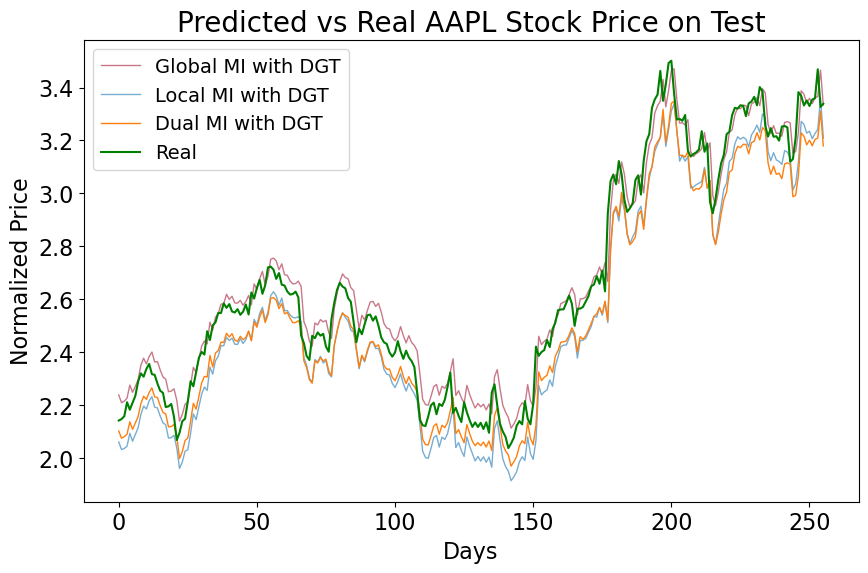

In [25]:
plot_regression([(DGT, True, 'mi', 'global', 0.01),
                (DGT, True, 'mi', 'local', 0.01),
                (DGT, True, 'mi', 'dual', 0.01)
                ],
                ['Global MI with DGT', 'Local MI with DGT', 'Dual MI with DGT'],
                stock_name='AAPL', fig_name=f'{workdir}/sp500_AAPL_MI.png', test_results=test_results)

## Dual Pearson Outperforms Global and Local

<Figure size 640x480 with 0 Axes>

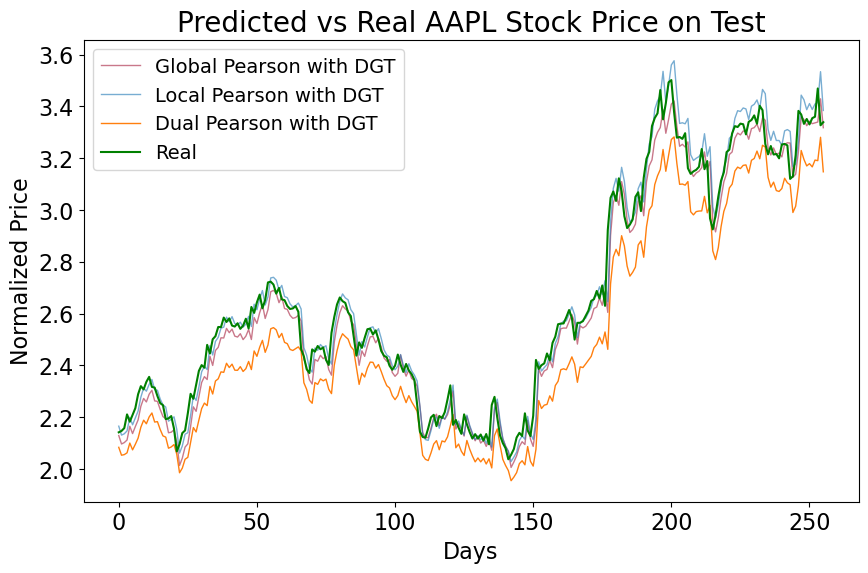

In [26]:
plot_regression([(DGT, True, 'pcc', 'global', 0.01),
                (DGT, True, 'pcc', 'local', 0.01),
                (DGT, True, 'pcc', 'dual', 0.01)],
                ['Global Pearson with DGT', 'Local Pearson with DGT', 'Dual Pearson with DGT'],
                stock_name='AAPL', fig_name=f'{workdir}/sp500_AAPL_PCC.png', test_results=test_results)

# Risk Management

In [27]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# ==========================================
# 1. SETUP GLOBAL (A exécuter une seule fois)
# ==========================================

# --- A. Récupération des stats de normalisation (Train Set) ---
df_raw = pd.read_csv(f'{workdir}/sp500.csv').set_index('Date')
days_in_quarter = 64
num_quarters = len(df_raw) // days_in_quarter
train_days = int(0.8 * num_quarters) * days_in_quarter

# On sauvegarde ces constantes pour le dénormaliseur
TRAIN_MEAN = df_raw.iloc[:train_days].mean().values
TRAIN_STD = df_raw.iloc[:train_days].std().values
COLS = df_raw.columns

🛡️ Lancement du Backtest SÉCURISÉ pour : (<class '__main__.DGT'>, False, None, None, 0.1)
Rendement Annuel : 29.82%
Volatilité       : 12.92%
Sharpe Ratio     : 2.31
Max Drawdown     : -7.22%


/var/folders/d1/dk7prgk94r7gtwzh0c5xmw0m0000gn/T/ipykernel_38567/3835914801.py:24: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  safe_vol = vol.shift(1).replace(0, 0.001).fillna(method='bfill')


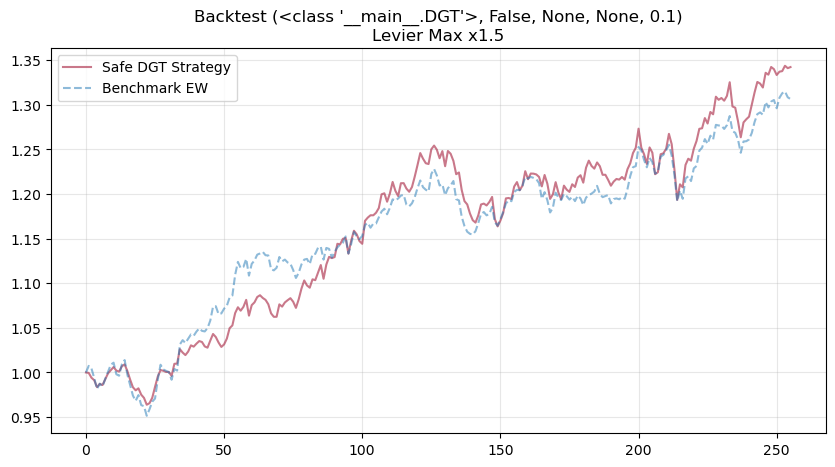

In [28]:
def backtest_model_safe(model_config, result, vol_window=60, target_vol=0.15, max_leverage=1.5, max_position=0.10):
    print(f"🛡️ Lancement du Backtest SÉCURISÉ pour : {model_config}")
    
    # --- A. Dénormalisation (Utilisation des globales) ---
    # Plus besoin de relire le CSV ici
    
    z_pred = result['y_hats'].cpu().numpy()
    z_true = result['ys'].cpu().numpy()
    
    # Utilisation directe des constantes globales définies plus haut
    price_pred = pd.DataFrame(z_pred * TRAIN_STD + TRAIN_MEAN, columns=COLS)
    price_true = pd.DataFrame(z_true * TRAIN_STD + TRAIN_MEAN, columns=COLS)
    
    # --- B. Calcul des Signaux ---
    real_returns = price_true.pct_change().fillna(0.0)
    prev_close = price_true.shift(1)
    pred_returns = (price_pred - prev_close) / prev_close
    pred_returns = pred_returns.fillna(0.0)
    
    # --- C. Construction du Portefeuille ---
    # 1. Volatilité (Passée uniquement)
    # On shift ici aussi par sécurité méthodologique (bien que le rolling inclut souvent t-1 en finance, mieux vaut être explicite)
    vol = real_returns.rolling(window=vol_window).std() * np.sqrt(252)
    safe_vol = vol.shift(1).replace(0, 0.001).fillna(method='bfill')
    
    # 2. Signal Brut
    raw_weights = pred_returns / safe_vol
    
    # 3. Normalisation (100% expo)
    gross_exposure = raw_weights.abs().sum(axis=1).replace(0, 1)
    normalized_weights = raw_weights.div(gross_exposure, axis=0)
    
    # 4. Levier Dynamique (Correction du Biais)
    est_port_ret = (normalized_weights * real_returns).mean(axis=1)
    port_vol = est_port_ret.rolling(20).std() * np.sqrt(252)
    
    # CORRECTION CRITIQUE : Shift(1) pour ne pas voir le futur
    port_vol = port_vol.shift(1).fillna(target_vol)
    
    lev_factor = (target_vol / port_vol.replace(0, 0.1))
    
    # 5. Sécurités
    final_leverage = lev_factor.clip(0, max_leverage)
    final_weights = normalized_weights.multiply(final_leverage, axis=0)
    final_weights = final_weights.clip(-max_position, max_position)
    
    # --- D. Performance ---
    turnover = (final_weights - final_weights.shift(1)).abs().sum(axis=1)
    costs = turnover * 0.0005 
    
    net_ret = (final_weights.shift(1) * real_returns).sum(axis=1) - costs
    net_ret = net_ret.fillna(0)
    
    # --- E. Metrics ---
    equity = (1 + net_ret).cumprod()
    ann_ret = net_ret.mean() * 252
    ann_vol = net_ret.std() * np.sqrt(252)
    sharpe = ann_ret / ann_vol if ann_vol > 0 else 0
    max_dd = (equity - equity.cummax()) / equity.cummax()
    max_dd = max_dd.min()
    
    print(f"Rendement Annuel : {ann_ret:.2%}")
    print(f"Volatilité       : {ann_vol:.2%}")
    print(f"Sharpe Ratio     : {sharpe:.2f}")
    print(f"Max Drawdown     : {max_dd:.2%}")
    
    plt.figure(figsize=(10, 5))
    plt.plot(equity, label='Safe DGT Strategy')
    plt.plot((1 + real_returns.mean(axis=1)).cumprod(), label='Benchmark EW', linestyle='--', alpha=0.5)
    plt.title(f"Backtest {model_config}\nLevier Max x{max_leverage}")
    plt.legend()
    plt.grid(True, alpha=0.3)
    plt.show()

# ==============================================================================
# 2. EXECUTION (Choisis ton modèle ici)
# ==============================================================================

# Exemple : On prend le premier modèle de la liste
# Tu peux changer l'index [0] par [1], [2] pour tester les autres
config = model_configs[1] 
result = test_results[config]
vol_window = 20
max_leverage = 1.5
max_position = 0.10

# LANCE LE TEST ICI
backtest_model_safe(
    model_config=config,
    result=result,
    vol_window=vol_window,
    max_leverage=max_leverage,
    max_position=max_position
)

# Benchmark Complet : Comparaison de Toutes les Configurations

In [29]:
def run_backtest_silent(model_config, result, vol_window=20, target_vol=0.15, max_leverage=1.5, max_position=0.10):
    """
    Version silencieuse du backtest qui retourne uniquement les métriques
    """
    z_pred = result['y_hats'].cpu().numpy()
    z_true = result['ys'].cpu().numpy()
    
    # Dénormalisation
    price_pred = pd.DataFrame(z_pred * TRAIN_STD + TRAIN_MEAN, columns=COLS)
    price_true = pd.DataFrame(z_true * TRAIN_STD + TRAIN_MEAN, columns=COLS)
    
    # Calcul des rendements
    real_returns = price_true.pct_change().fillna(0.0)
    prev_close = price_true.shift(1)
    pred_returns = (price_pred - prev_close) / prev_close
    pred_returns = pred_returns.fillna(0.0)
    
    # Volatilité
    vol = real_returns.rolling(window=vol_window).std() * np.sqrt(252)
    safe_vol = vol.shift(1).replace(0, 0.001).fillna(method='bfill')
    
    # Signal
    raw_weights = pred_returns / safe_vol
    gross_exposure = raw_weights.abs().sum(axis=1).replace(0, 1)
    normalized_weights = raw_weights.div(gross_exposure, axis=0)
    
    # Levier dynamique
    est_port_ret = (normalized_weights * real_returns).mean(axis=1)
    port_vol = est_port_ret.rolling(20).std() * np.sqrt(252)
    port_vol = port_vol.shift(1).fillna(target_vol)
    lev_factor = (target_vol / port_vol.replace(0, 0.1))
    
    # Sécurités
    final_leverage = lev_factor.clip(0, max_leverage)
    final_weights = normalized_weights.multiply(final_leverage, axis=0)
    final_weights = final_weights.clip(-max_position, max_position)
    
    # Performance
    turnover = (final_weights - final_weights.shift(1)).abs().sum(axis=1)
    costs = turnover * 0.0005
    net_ret = (final_weights.shift(1) * real_returns).sum(axis=1) - costs
    net_ret = net_ret.fillna(0)
    
    # Metrics
    equity = (1 + net_ret).cumprod()
    ann_ret = net_ret.mean() * 252
    ann_vol = net_ret.std() * np.sqrt(252)
    sharpe = ann_ret / ann_vol if ann_vol > 0 else 0
    max_dd = ((equity - equity.cummax()) / equity.cummax()).min()
    
    # Calmar Ratio (rendement annuel / max drawdown)
    calmar = abs(ann_ret / max_dd) if max_dd != 0 else 0
    
    # Sortino Ratio (rendement ajusté par downside deviation)
    downside_returns = net_ret[net_ret < 0]
    downside_vol = downside_returns.std() * np.sqrt(252) if len(downside_returns) > 0 else 0.0001
    sortino = ann_ret / downside_vol
    
    # Win Rate
    win_rate = (net_ret > 0).sum() / len(net_ret)
    
    # Moyenne des coûts de transaction
    avg_turnover = turnover.mean()
    avg_costs = costs.mean() * 252  # Annualisé
    
    return {
        'equity_curve': equity,
        'returns': net_ret,
        'ann_return': ann_ret,
        'ann_vol': ann_vol,
        'sharpe': sharpe,
        'sortino': sortino,
        'calmar': calmar,
        'max_dd': max_dd,
        'win_rate': win_rate,
        'avg_turnover': avg_turnover,
        'avg_costs': avg_costs
    }

## Exécution du Benchmark sur Tous les Modèles

In [30]:
# Paramètres de risk management pour le benchmark
BENCHMARK_PARAMS = {
    'vol_window': 20,
    'target_vol': 0.15,
    'max_leverage': 1.5,
    'max_position': 0.10
}

# Exécution du benchmark sur tous les modèles
print("🚀 Lancement du benchmark complet...")
print("=" * 80)

benchmark_results = {}
for i, config in enumerate(model_configs, 1):
    gnn, use_spatial, corr_name, corr_scope, lr = config
    model_name = f"{gnn.__name__}"
    if use_spatial:
        model_name += "_spatial"
    if corr_name:
        model_name += f"_{corr_name}_{corr_scope}"
    
    print(f"\n[{i}/{len(model_configs)}] Testing: {model_name}")
    
    result = test_results[config]
    metrics = run_backtest_silent(config, result, **BENCHMARK_PARAMS)
    
    benchmark_results[model_name] = {
        'config': config,
        'metrics': metrics,
        'rmse': result['rmse'],
        'mae': result['mae']
    }
    
    print(f"  ✓ Sharpe: {metrics['sharpe']:.3f} | Return: {metrics['ann_return']:.2%} | DD: {metrics['max_dd']:.2%}")

print("\n" + "=" * 80)
print("✅ Benchmark terminé!")

🚀 Lancement du benchmark complet...

[1/9] Testing: GRU
  ✓ Sharpe: -2.402 | Return: -37.92% | DD: -34.99%

[2/9] Testing: DGT


/var/folders/d1/dk7prgk94r7gtwzh0c5xmw0m0000gn/T/ipykernel_38567/568638580.py:20: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  safe_vol = vol.shift(1).replace(0, 0.001).fillna(method='bfill')
/var/folders/d1/dk7prgk94r7gtwzh0c5xmw0m0000gn/T/ipykernel_38567/568638580.py:20: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  safe_vol = vol.shift(1).replace(0, 0.001).fillna(method='bfill')


  ✓ Sharpe: 2.308 | Return: 29.82% | DD: -7.22%

[3/9] Testing: DGT_spatial
  ✓ Sharpe: 0.719 | Return: 7.31% | DD: -9.11%

[4/9] Testing: DGT_spatial_mi_global
  ✓ Sharpe: 0.733 | Return: 5.17% | DD: -4.07%

[5/9] Testing: DGT_spatial_mi_local
  ✓ Sharpe: -2.142 | Return: -39.77% | DD: -39.90%

[6/9] Testing: DGT_spatial_mi_dual
  ✓ Sharpe: -1.938 | Return: -13.04% | DD: -13.82%

[7/9] Testing: DGT_spatial_pcc_global


/var/folders/d1/dk7prgk94r7gtwzh0c5xmw0m0000gn/T/ipykernel_38567/568638580.py:20: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  safe_vol = vol.shift(1).replace(0, 0.001).fillna(method='bfill')
/var/folders/d1/dk7prgk94r7gtwzh0c5xmw0m0000gn/T/ipykernel_38567/568638580.py:20: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  safe_vol = vol.shift(1).replace(0, 0.001).fillna(method='bfill')
/var/folders/d1/dk7prgk94r7gtwzh0c5xmw0m0000gn/T/ipykernel_38567/568638580.py:20: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  safe_vol = vol.shift(1).replace(0, 0.001).fillna(method='bfill')
/var/folders/d1/dk7prgk94r7gtwzh0c5xmw0m0000gn/T/ipykernel_38567/568638580.py:20: FutureWarning: DataFrame.fillna with 'method' is deprecated and

  ✓ Sharpe: -2.411 | Return: -18.04% | DD: -19.75%

[8/9] Testing: DGT_spatial_pcc_local
  ✓ Sharpe: 0.872 | Return: 10.19% | DD: -5.74%

[9/9] Testing: DGT_spatial_pcc_dual
  ✓ Sharpe: 0.042 | Return: 0.32% | DD: -7.13%

✅ Benchmark terminé!


/var/folders/d1/dk7prgk94r7gtwzh0c5xmw0m0000gn/T/ipykernel_38567/568638580.py:20: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  safe_vol = vol.shift(1).replace(0, 0.001).fillna(method='bfill')
/var/folders/d1/dk7prgk94r7gtwzh0c5xmw0m0000gn/T/ipykernel_38567/568638580.py:20: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  safe_vol = vol.shift(1).replace(0, 0.001).fillna(method='bfill')


## Tableau Comparatif des Performances

In [31]:
# Création du tableau comparatif
comparison_data = []

for model_name, data in benchmark_results.items():
    metrics = data['metrics']
    comparison_data.append({
        'Model': model_name,
        'RMSE': data['rmse'],
        'MAE': data['mae'],
        'Annual Return': metrics['ann_return'],
        'Annual Vol': metrics['ann_vol'],
        'Sharpe Ratio': metrics['sharpe'],
        'Sortino Ratio': metrics['sortino'],
        'Calmar Ratio': metrics['calmar'],
        'Max Drawdown': metrics['max_dd'],
        'Win Rate': metrics['win_rate'],
        'Avg Turnover': metrics['avg_turnover'],
        'Avg Annual Costs': metrics['avg_costs']
    })

df_comparison = pd.DataFrame(comparison_data)

# Tri par Sharpe Ratio (décroissant)
df_comparison = df_comparison.sort_values(by='Sharpe Ratio', ascending=False)

# Formatage pour l'affichage
df_display = df_comparison.copy()
df_display['RMSE'] = df_display['RMSE'].apply(lambda x: f"{x:.4f}")
df_display['MAE'] = df_display['MAE'].apply(lambda x: f"{x:.4f}")
df_display['Annual Return'] = df_display['Annual Return'].apply(lambda x: f"{x:.2%}")
df_display['Annual Vol'] = df_display['Annual Vol'].apply(lambda x: f"{x:.2%}")
df_display['Sharpe Ratio'] = df_display['Sharpe Ratio'].apply(lambda x: f"{x:.3f}")
df_display['Sortino Ratio'] = df_display['Sortino Ratio'].apply(lambda x: f"{x:.3f}")
df_display['Calmar Ratio'] = df_display['Calmar Ratio'].apply(lambda x: f"{x:.3f}")
df_display['Max Drawdown'] = df_display['Max Drawdown'].apply(lambda x: f"{x:.2%}")
df_display['Win Rate'] = df_display['Win Rate'].apply(lambda x: f"{x:.2%}")
df_display['Avg Turnover'] = df_display['Avg Turnover'].apply(lambda x: f"{x:.2f}")
df_display['Avg Annual Costs'] = df_display['Avg Annual Costs'].apply(lambda x: f"{x:.2%}")

print("\n" + "="*120)
print("📊 TABLEAU COMPARATIF COMPLET - TOUTES LES CONFIGURATIONS")
print("="*120)
display(df_display)

# Highlight du meilleur modèle
best_model = df_comparison.iloc[0]['Model']
best_sharpe = df_comparison.iloc[0]['Sharpe Ratio']
print(f"\n🏆 MEILLEUR MODÈLE: {best_model} (Sharpe: {best_sharpe:.3f})")


📊 TABLEAU COMPARATIF COMPLET - TOUTES LES CONFIGURATIONS


,Model,RMSE,MAE,Annual Return,Annual Vol,Sharpe Ratio,Sortino Ratio,Calmar Ratio,Max Drawdown,Win Rate,Avg Turnover,Avg Annual Costs
1,DGT,0.4329,0.1817,29.82%,12.92%,2.308,3.614,4.131,-7.22%,53.91%,0.13,1.58%
7,DGT_spatial_pcc_local,0.2941,0.0868,10.19%,11.68%,0.872,1.456,1.774,-5.74%,51.95%,0.20,2.53%
3,DGT_spatial_mi_global,0.4651,0.1149,5.17%,7.05%,0.733,1.322,1.269,-4.07%,49.22%,0.15,1.95%
2,DGT_spatial,1.4737,0.2925,7.31%,10.17%,0.719,1.389,0.802,-9.11%,47.66%,0.12,1.52%
8,DGT_spatial_pcc_dual,0.2968,0.1574,0.32%,7.73%,0.042,0.078,0.045,-7.13%,46.88%,0.14,1.82%
5,DGT_spatial_mi_dual,0.2599,0.0993,-13.04%,6.73%,-1.938,-3.455,0.944,-13.82%,41.80%,0.17,2.09%
4,DGT_spatial_mi_local,0.3242,0.1340,-39.77%,18.56%,-2.142,-3.174,0.997,-39.90%,41.02%,0.12,1.48%
0,GRU,3.1166,0.4076,-37.92%,15.79%,-2.402,-3.767,1.084,-34.99%,42.97%,0.13,1.62%
6,DGT_spatial_pcc_global,0.6430,0.1480,-18.04%,7.48%,-2.411,-3.446,0.913,-19.75%,45.31%,0.15,1.83%



🏆 MEILLEUR MODÈLE: DGT (Sharpe: 2.308)


## Visualisation: Courbes d'Équité Comparatives

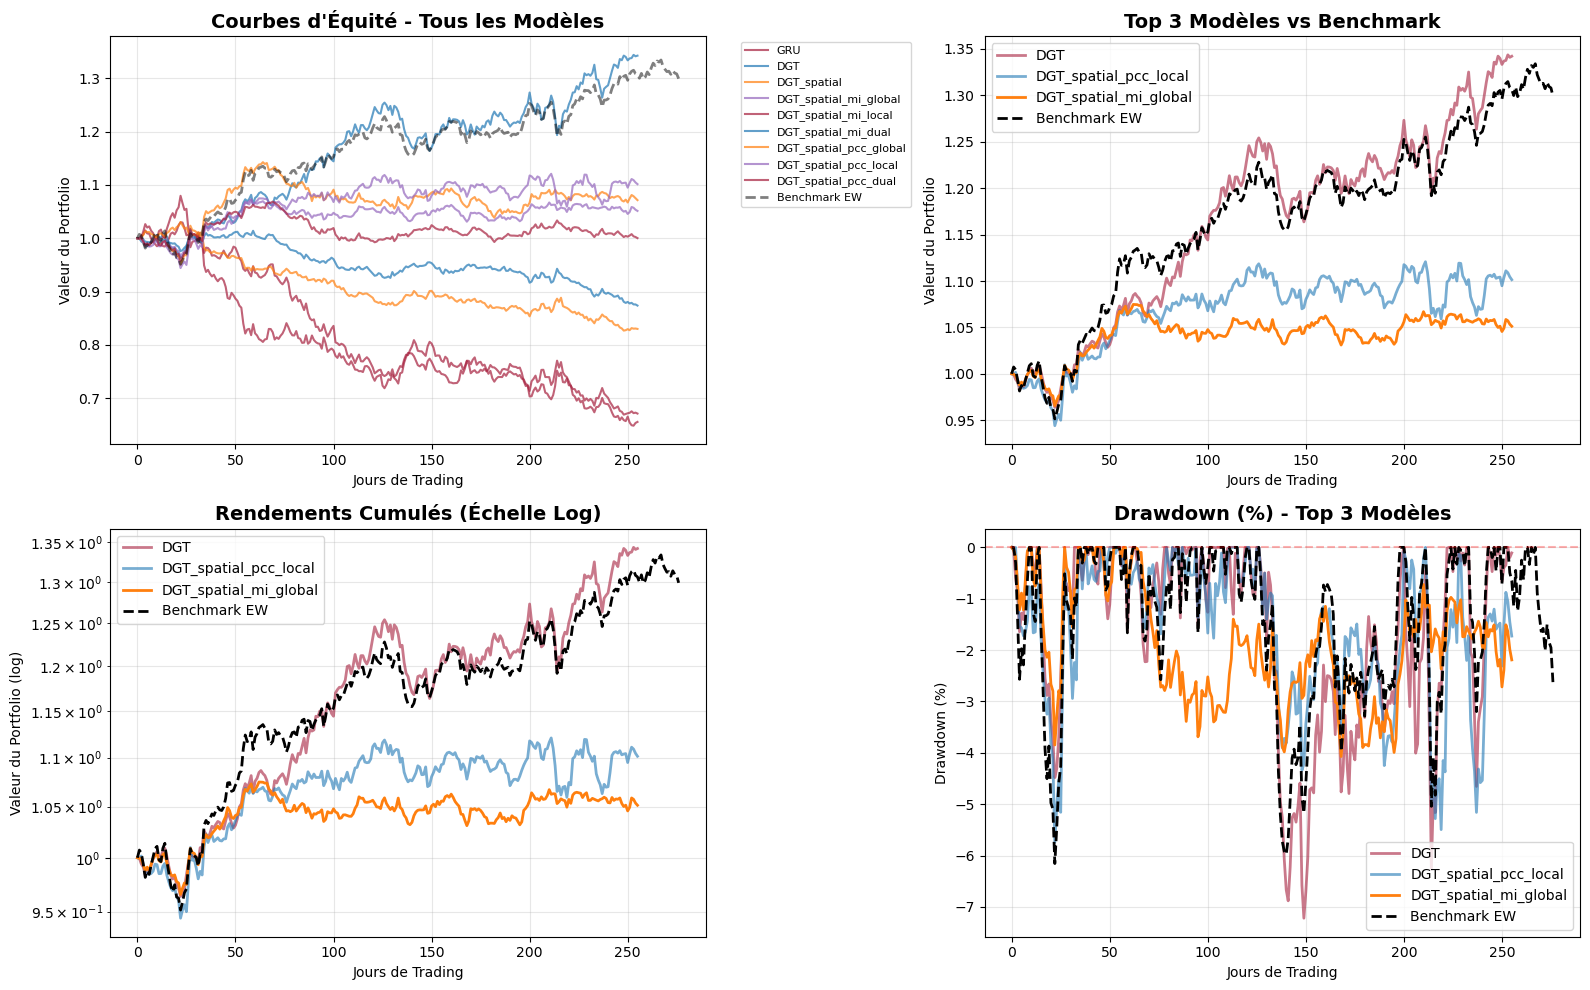

📈 Graphiques sauvegardés dans: benchmark_comparison.png


In [32]:
# Graphique comparatif des courbes d'équité
plt.figure(figsize=(16, 10))

# Calculer le benchmark Equal Weight
df_raw = pd.read_csv(f'{workdir}/sp500.csv').set_index('Date')
num_quarters = len(df_raw) // days_in_quarter
test_start = int(0.9 * num_quarters) * days_in_quarter
test_data = df_raw.iloc[test_start:]
ew_returns = test_data.pct_change().mean(axis=1).fillna(0)
ew_equity = (1 + ew_returns).cumprod()

# Plot 1: Toutes les courbes ensemble
plt.subplot(2, 2, 1)
for model_name, data in benchmark_results.items():
    equity = data['metrics']['equity_curve']
    plt.plot(equity.values, label=model_name, alpha=0.7, linewidth=1.5)
plt.plot(ew_equity.values, label='Benchmark EW', linestyle='--', color='black', linewidth=2, alpha=0.5)
plt.title('Courbes d\'Équité - Tous les Modèles', fontsize=14, fontweight='bold')
plt.xlabel('Jours de Trading')
plt.ylabel('Valeur du Portfolio')
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left', fontsize=8)
plt.grid(True, alpha=0.3)

# Plot 2: Top 3 modèles vs Benchmark
plt.subplot(2, 2, 2)
top_3 = df_comparison.head(3)['Model'].tolist()
for model_name in top_3:
    equity = benchmark_results[model_name]['metrics']['equity_curve']
    plt.plot(equity.values, label=model_name, linewidth=2)
plt.plot(ew_equity.values, label='Benchmark EW', linestyle='--', color='black', linewidth=2)
plt.title('Top 3 Modèles vs Benchmark', fontsize=14, fontweight='bold')
plt.xlabel('Jours de Trading')
plt.ylabel('Valeur du Portfolio')
plt.legend(fontsize=10)
plt.grid(True, alpha=0.3)

# Plot 3: Rendements cumulés (log scale)
plt.subplot(2, 2, 3)
for model_name in top_3:
    equity = benchmark_results[model_name]['metrics']['equity_curve']
    plt.semilogy(equity.values, label=model_name, linewidth=2)
plt.semilogy(ew_equity.values, label='Benchmark EW', linestyle='--', color='black', linewidth=2)
plt.title('Rendements Cumulés (Échelle Log)', fontsize=14, fontweight='bold')
plt.xlabel('Jours de Trading')
plt.ylabel('Valeur du Portfolio (log)')
plt.legend(fontsize=10)
plt.grid(True, alpha=0.3, which="both")

# Plot 4: Drawdowns des top 3
plt.subplot(2, 2, 4)
for model_name in top_3:
    equity = benchmark_results[model_name]['metrics']['equity_curve']
    drawdown = (equity - equity.cummax()) / equity.cummax()
    plt.plot(drawdown.values * 100, label=model_name, linewidth=2)
ew_drawdown = (ew_equity - ew_equity.cummax()) / ew_equity.cummax()
plt.plot(ew_drawdown.values * 100, label='Benchmark EW', linestyle='--', color='black', linewidth=2)
plt.title('Drawdown (%) - Top 3 Modèles', fontsize=14, fontweight='bold')
plt.xlabel('Jours de Trading')
plt.ylabel('Drawdown (%)')
plt.legend(fontsize=10)
plt.grid(True, alpha=0.3)
plt.axhline(y=0, color='red', linestyle='--', alpha=0.3)

plt.tight_layout()
plt.savefig(f'{workdir}/benchmark_comparison.png', dpi=150, bbox_inches='tight')
plt.show()

print("📈 Graphiques sauvegardés dans: benchmark_comparison.png")

## Comparaison des Métriques Clés (Graphiques en Barres)

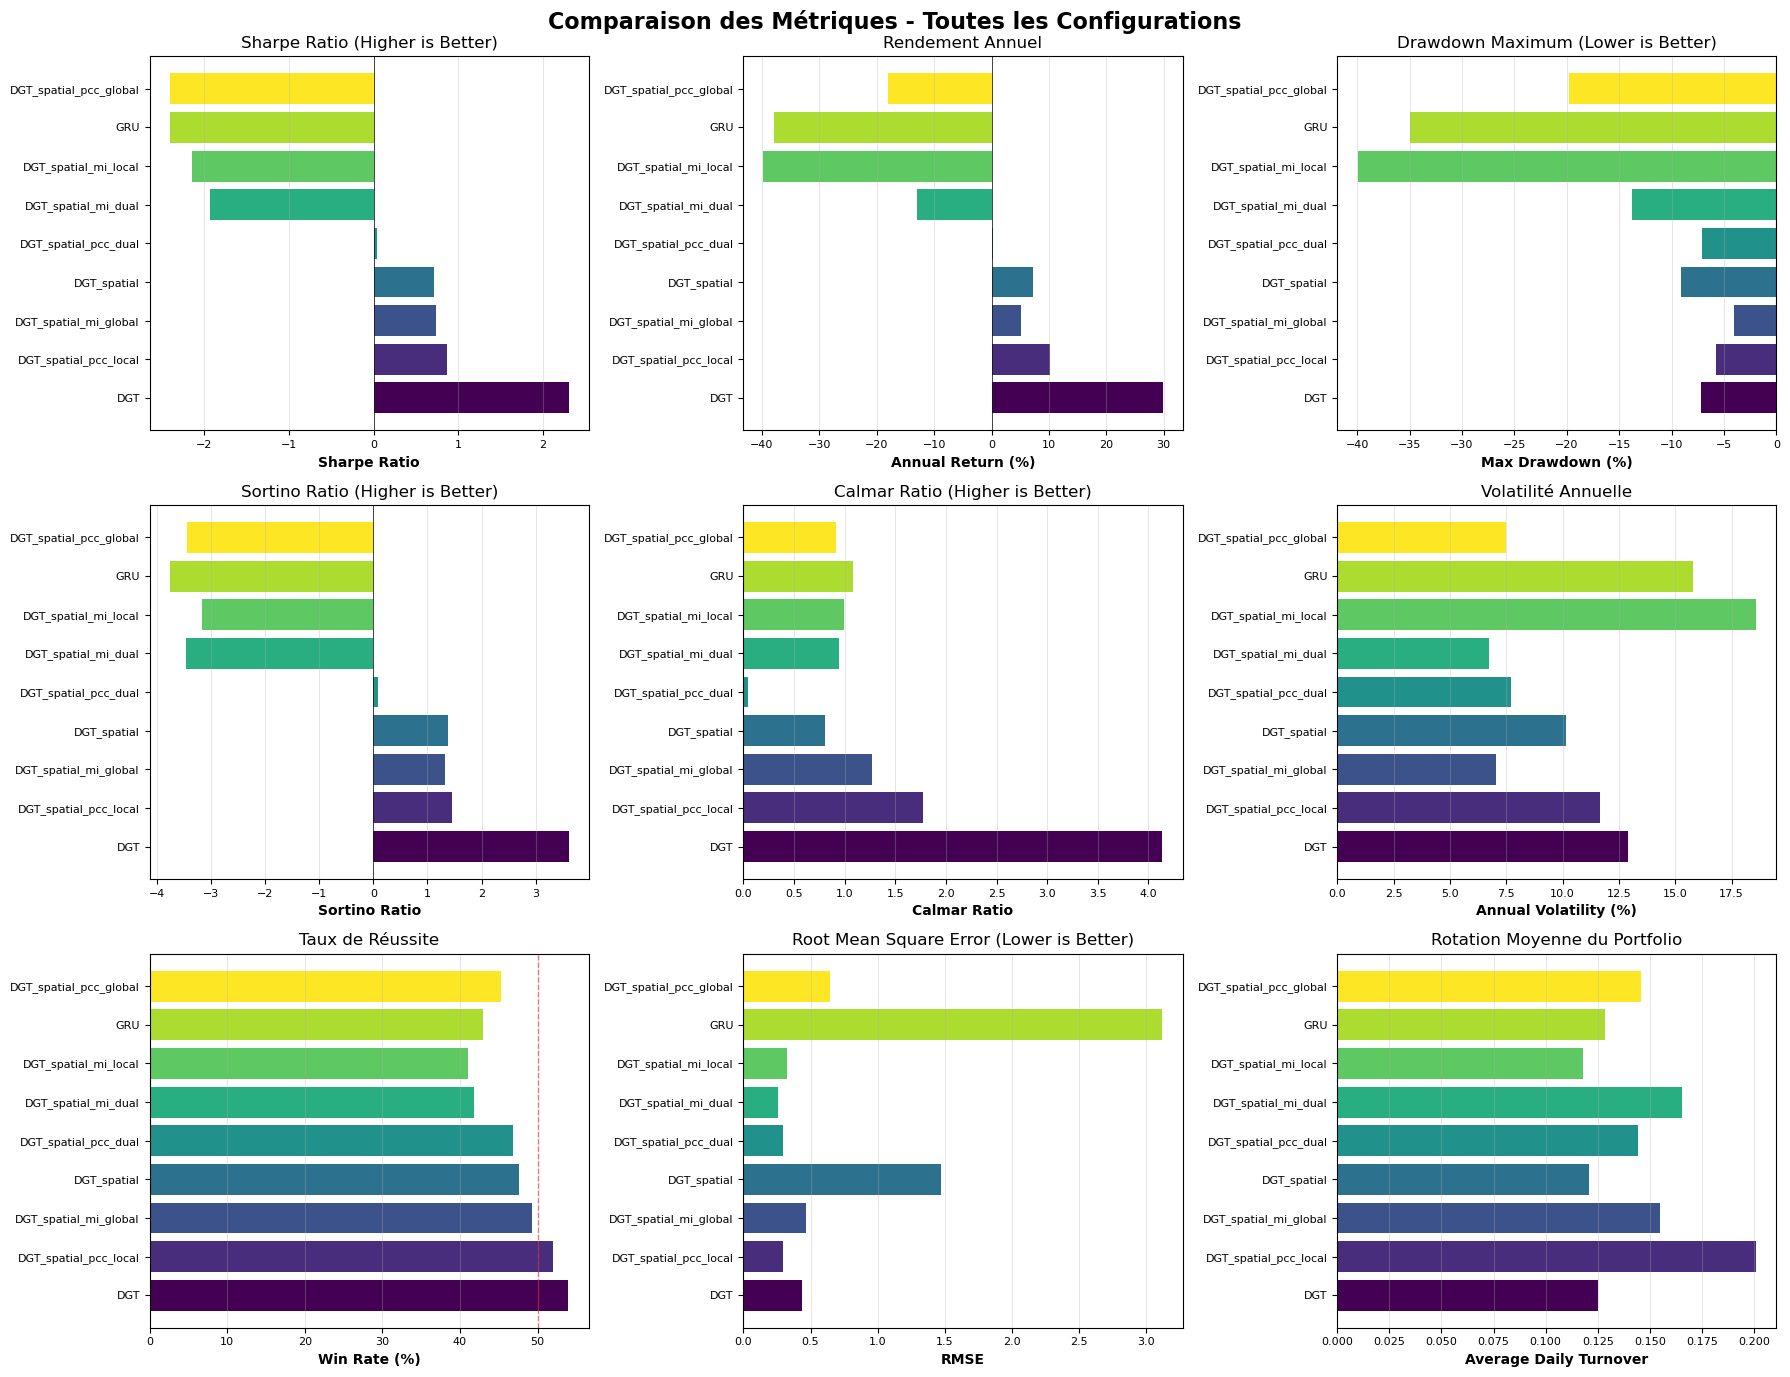

📊 Graphiques sauvegardés dans: benchmark_metrics_bars.png


In [33]:
# Graphiques en barres pour les métriques clés
fig, axes = plt.subplots(3, 3, figsize=(18, 14))
fig.suptitle('Comparaison des Métriques - Toutes les Configurations', fontsize=16, fontweight='bold')

models = df_comparison['Model'].tolist()
colors = plt.cm.viridis(np.linspace(0, 1, len(models)))

# 1. Sharpe Ratio
ax = axes[0, 0]
sharpe_values = [benchmark_results[m]['metrics']['sharpe'] for m in models]
bars = ax.barh(models, sharpe_values, color=colors)
ax.set_xlabel('Sharpe Ratio', fontweight='bold')
ax.set_title('Sharpe Ratio (Higher is Better)')
ax.axvline(x=0, color='black', linestyle='-', linewidth=0.5)
ax.grid(True, alpha=0.3, axis='x')

# 2. Annual Return
ax = axes[0, 1]
returns = [benchmark_results[m]['metrics']['ann_return'] * 100 for m in models]
ax.barh(models, returns, color=colors)
ax.set_xlabel('Annual Return (%)', fontweight='bold')
ax.set_title('Rendement Annuel')
ax.axvline(x=0, color='black', linestyle='-', linewidth=0.5)
ax.grid(True, alpha=0.3, axis='x')

# 3. Max Drawdown
ax = axes[0, 2]
dd_values = [benchmark_results[m]['metrics']['max_dd'] * 100 for m in models]
ax.barh(models, dd_values, color=colors)
ax.set_xlabel('Max Drawdown (%)', fontweight='bold')
ax.set_title('Drawdown Maximum (Lower is Better)')
ax.axvline(x=0, color='black', linestyle='-', linewidth=0.5)
ax.grid(True, alpha=0.3, axis='x')

# 4. Sortino Ratio
ax = axes[1, 0]
sortino_values = [benchmark_results[m]['metrics']['sortino'] for m in models]
ax.barh(models, sortino_values, color=colors)
ax.set_xlabel('Sortino Ratio', fontweight='bold')
ax.set_title('Sortino Ratio (Higher is Better)')
ax.axvline(x=0, color='black', linestyle='-', linewidth=0.5)
ax.grid(True, alpha=0.3, axis='x')

# 5. Calmar Ratio
ax = axes[1, 1]
calmar_values = [benchmark_results[m]['metrics']['calmar'] for m in models]
ax.barh(models, calmar_values, color=colors)
ax.set_xlabel('Calmar Ratio', fontweight='bold')
ax.set_title('Calmar Ratio (Higher is Better)')
ax.axvline(x=0, color='black', linestyle='-', linewidth=0.5)
ax.grid(True, alpha=0.3, axis='x')

# 6. Annual Volatility
ax = axes[1, 2]
vol_values = [benchmark_results[m]['metrics']['ann_vol'] * 100 for m in models]
ax.barh(models, vol_values, color=colors)
ax.set_xlabel('Annual Volatility (%)', fontweight='bold')
ax.set_title('Volatilité Annuelle')
ax.grid(True, alpha=0.3, axis='x')

# 7. Win Rate
ax = axes[2, 0]
win_rate_values = [benchmark_results[m]['metrics']['win_rate'] * 100 for m in models]
ax.barh(models, win_rate_values, color=colors)
ax.set_xlabel('Win Rate (%)', fontweight='bold')
ax.set_title('Taux de Réussite')
ax.axvline(x=50, color='red', linestyle='--', linewidth=1, alpha=0.5)
ax.grid(True, alpha=0.3, axis='x')

# 8. RMSE (Prediction Error)
ax = axes[2, 1]
rmse_values = [benchmark_results[m]['rmse'] for m in models]
ax.barh(models, rmse_values, color=colors)
ax.set_xlabel('RMSE', fontweight='bold')
ax.set_title('Root Mean Square Error (Lower is Better)')
ax.grid(True, alpha=0.3, axis='x')

# 9. Average Turnover
ax = axes[2, 2]
turnover_values = [benchmark_results[m]['metrics']['avg_turnover'] for m in models]
ax.barh(models, turnover_values, color=colors)
ax.set_xlabel('Average Daily Turnover', fontweight='bold')
ax.set_title('Rotation Moyenne du Portfolio')
ax.grid(True, alpha=0.3, axis='x')

# Ajuster les tailles de police
for ax in axes.flat:
    ax.tick_params(axis='both', labelsize=8)
    
plt.tight_layout()
plt.savefig(f'{workdir}/benchmark_metrics_bars.png', dpi=150, bbox_inches='tight')
plt.show()

print("📊 Graphiques sauvegardés dans: benchmark_metrics_bars.png")

## Analyse Risk-Adjusted Performance: Scatter Plots

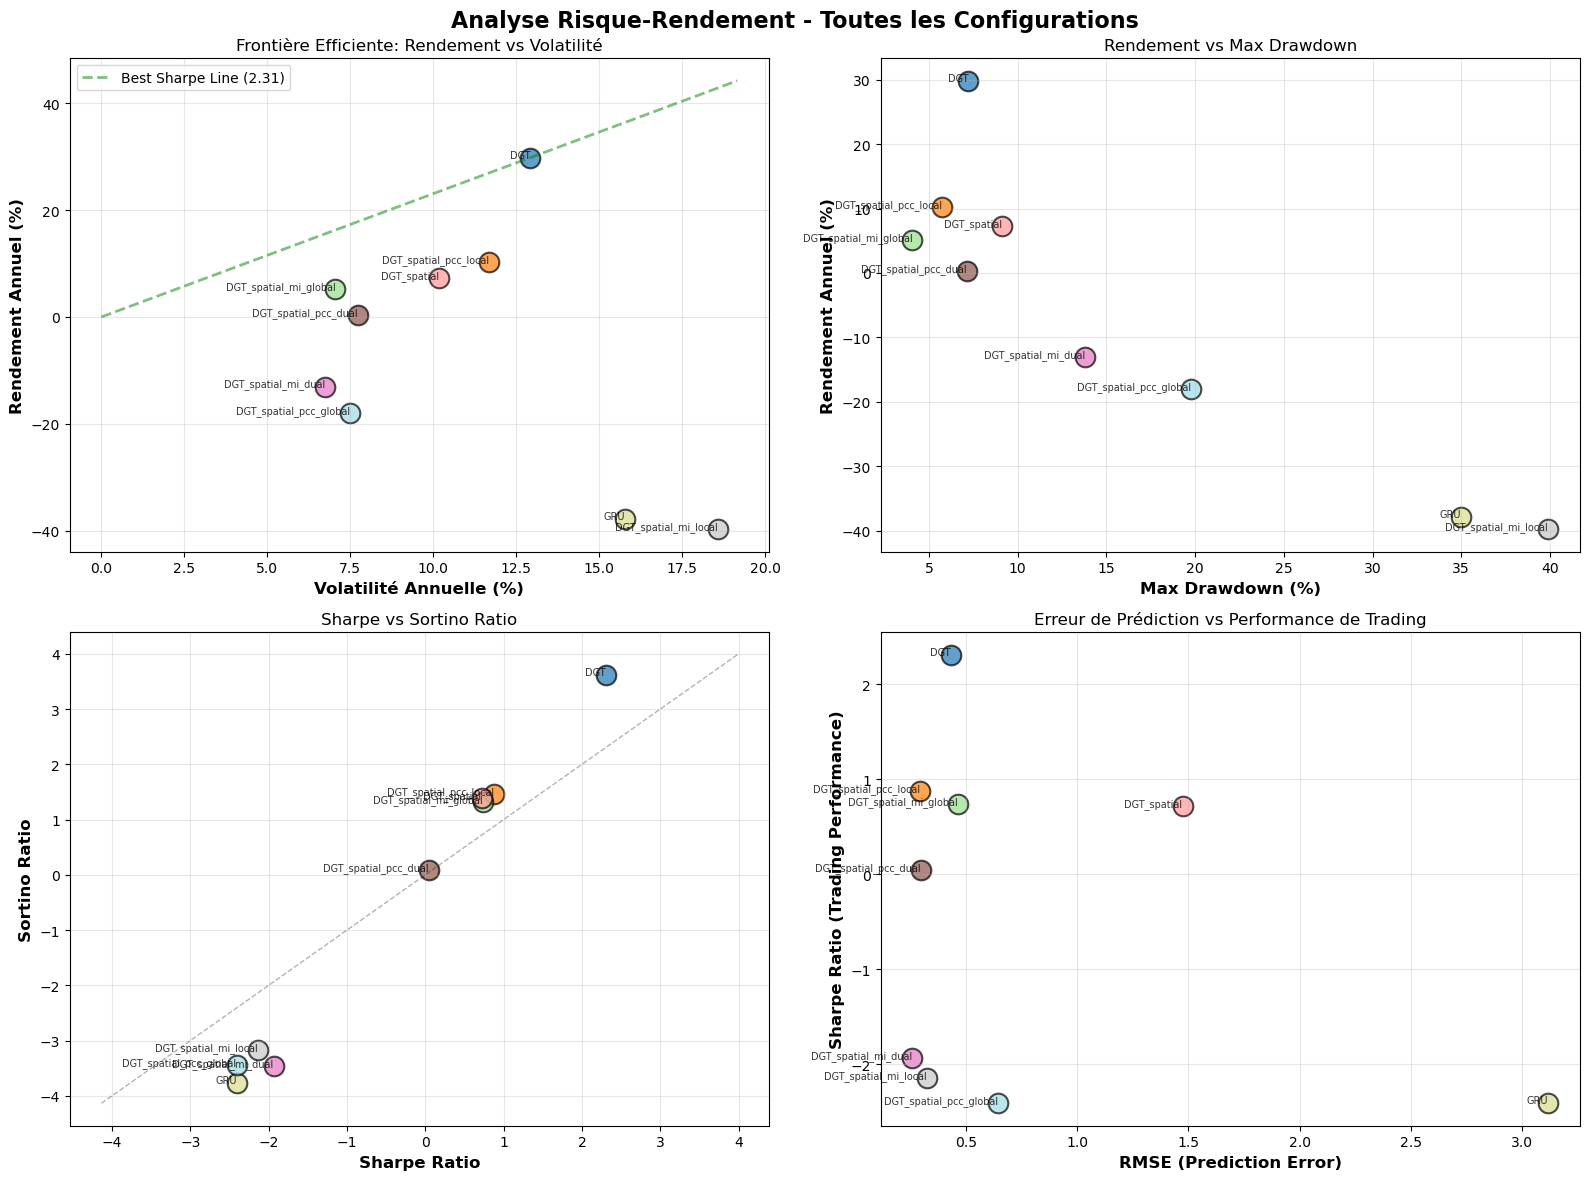

📉 Graphiques sauvegardés dans: benchmark_risk_analysis.png


In [34]:
# Scatter plots pour l'analyse risque-rendement
fig, axes = plt.subplots(2, 2, figsize=(16, 12))
fig.suptitle('Analyse Risque-Rendement - Toutes les Configurations', fontsize=16, fontweight='bold')

models = df_comparison['Model'].tolist()
colors_scatter = plt.cm.tab20(np.linspace(0, 1, len(models)))

# 1. Return vs Volatility (Efficient Frontier)
ax = axes[0, 0]
for i, model_name in enumerate(models):
    metrics = benchmark_results[model_name]['metrics']
    ax.scatter(metrics['ann_vol'] * 100, metrics['ann_return'] * 100, 
               s=200, alpha=0.7, color=colors_scatter[i], edgecolors='black', linewidth=1.5)
    ax.annotate(model_name, (metrics['ann_vol'] * 100, metrics['ann_return'] * 100),
                fontsize=7, ha='right', alpha=0.8)

# Ligne de Capital Market
best_sharpe_model = df_comparison.iloc[0]['Model']
best_sharpe_val = benchmark_results[best_sharpe_model]['metrics']['sharpe']
x_line = np.linspace(0, ax.get_xlim()[1], 100)
y_line = best_sharpe_val * x_line
ax.plot(x_line, y_line, 'g--', alpha=0.5, linewidth=2, label=f'Best Sharpe Line ({best_sharpe_val:.2f})')

ax.set_xlabel('Volatilité Annuelle (%)', fontweight='bold', fontsize=12)
ax.set_ylabel('Rendement Annuel (%)', fontweight='bold', fontsize=12)
ax.set_title('Frontière Efficiente: Rendement vs Volatilité')
ax.grid(True, alpha=0.3)
ax.legend()

# 2. Return vs Max Drawdown
ax = axes[0, 1]
for i, model_name in enumerate(models):
    metrics = benchmark_results[model_name]['metrics']
    ax.scatter(abs(metrics['max_dd']) * 100, metrics['ann_return'] * 100,
               s=200, alpha=0.7, color=colors_scatter[i], edgecolors='black', linewidth=1.5)
    ax.annotate(model_name, (abs(metrics['max_dd']) * 100, metrics['ann_return'] * 100),
                fontsize=7, ha='right', alpha=0.8)

ax.set_xlabel('Max Drawdown (%)', fontweight='bold', fontsize=12)
ax.set_ylabel('Rendement Annuel (%)', fontweight='bold', fontsize=12)
ax.set_title('Rendement vs Max Drawdown')
ax.grid(True, alpha=0.3)

# 3. Sharpe vs Sortino
ax = axes[1, 0]
for i, model_name in enumerate(models):
    metrics = benchmark_results[model_name]['metrics']
    ax.scatter(metrics['sharpe'], metrics['sortino'],
               s=200, alpha=0.7, color=colors_scatter[i], edgecolors='black', linewidth=1.5,
               label=model_name)
    ax.annotate(model_name, (metrics['sharpe'], metrics['sortino']),
                fontsize=7, ha='right', alpha=0.8)

# Ligne diagonale de référence
lims = [min(ax.get_xlim()[0], ax.get_ylim()[0]), max(ax.get_xlim()[1], ax.get_ylim()[1])]
ax.plot(lims, lims, 'k--', alpha=0.3, linewidth=1)

ax.set_xlabel('Sharpe Ratio', fontweight='bold', fontsize=12)
ax.set_ylabel('Sortino Ratio', fontweight='bold', fontsize=12)
ax.set_title('Sharpe vs Sortino Ratio')
ax.grid(True, alpha=0.3)

# 4. RMSE vs Sharpe Ratio (Prediction vs Trading Performance)
ax = axes[1, 1]
for i, model_name in enumerate(models):
    rmse = benchmark_results[model_name]['rmse']
    sharpe = benchmark_results[model_name]['metrics']['sharpe']
    ax.scatter(rmse, sharpe,
               s=200, alpha=0.7, color=colors_scatter[i], edgecolors='black', linewidth=1.5)
    ax.annotate(model_name, (rmse, sharpe),
                fontsize=7, ha='right', alpha=0.8)

ax.set_xlabel('RMSE (Prediction Error)', fontweight='bold', fontsize=12)
ax.set_ylabel('Sharpe Ratio (Trading Performance)', fontweight='bold', fontsize=12)
ax.set_title('Erreur de Prédiction vs Performance de Trading')
ax.grid(True, alpha=0.3)

plt.tight_layout()
plt.savefig(f'{workdir}/benchmark_risk_analysis.png', dpi=150, bbox_inches='tight')
plt.show()

print("📉 Graphiques sauvegardés dans: benchmark_risk_analysis.png")

## Analyse par Type de Modèle et Corrélation

In [35]:
# Analyse détaillée par type de modèle
print("\n" + "="*80)
print("📊 ANALYSE PAR TYPE DE MODÈLE")
print("="*80)

# Grouper par architecture
gru_models = [m for m in models if 'GRU' in m]
dgt_no_spatial = [m for m in models if 'DGT' in m and 'spatial' not in m]
dgt_spatial = [m for m in models if 'DGT_spatial' in m]

print("\n🔹 GRU Baseline:")
for model_name in gru_models:
    metrics = benchmark_results[model_name]['metrics']
    print(f"  {model_name}: Sharpe={metrics['sharpe']:.3f}, Return={metrics['ann_return']:.2%}, DD={metrics['max_dd']:.2%}")

print("\n🔹 DGT sans Spatial Attention:")
for model_name in dgt_no_spatial:
    metrics = benchmark_results[model_name]['metrics']
    print(f"  {model_name}: Sharpe={metrics['sharpe']:.3f}, Return={metrics['ann_return']:.2%}, DD={metrics['max_dd']:.2%}")

print("\n🔹 DGT avec Spatial Attention:")
mi_models = [m for m in dgt_spatial if 'mi' in m]
pcc_models = [m for m in dgt_spatial if 'pcc' in m]

print("\n  📈 Avec Mutual Information:")
for model_name in mi_models:
    metrics = benchmark_results[model_name]['metrics']
    print(f"    {model_name}: Sharpe={metrics['sharpe']:.3f}, Return={metrics['ann_return']:.2%}, DD={metrics['max_dd']:.2%}")

print("\n  📈 Avec Pearson Correlation:")
for model_name in pcc_models:
    metrics = benchmark_results[model_name]['metrics']
    print(f"    {model_name}: Sharpe={metrics['sharpe']:.3f}, Return={metrics['ann_return']:.2%}, DD={metrics['max_dd']:.2%}")

# Statistiques par groupe
print("\n" + "="*80)
print("📊 STATISTIQUES MOYENNES PAR GROUPE")
print("="*80)

def calc_group_stats(model_list):
    if not model_list:
        return None
    sharpes = [benchmark_results[m]['metrics']['sharpe'] for m in model_list]
    returns = [benchmark_results[m]['metrics']['ann_return'] for m in model_list]
    dds = [benchmark_results[m]['metrics']['max_dd'] for m in model_list]
    return {
        'avg_sharpe': np.mean(sharpes),
        'avg_return': np.mean(returns),
        'avg_dd': np.mean(dds),
        'count': len(model_list)
    }

groups = {
    'GRU Baseline': gru_models,
    'DGT No Spatial': dgt_no_spatial,
    'DGT + MI': mi_models,
    'DGT + PCC': pcc_models
}

for group_name, group_models in groups.items():
    stats = calc_group_stats(group_models)
    if stats:
        print(f"\n{group_name} ({stats['count']} modèles):")
        print(f"  Sharpe Moyen: {stats['avg_sharpe']:.3f}")
        print(f"  Return Moyen: {stats['avg_return']:.2%}")
        print(f"  Max DD Moyen: {stats['avg_dd']:.2%}")


📊 ANALYSE PAR TYPE DE MODÈLE

🔹 GRU Baseline:
  GRU: Sharpe=-2.402, Return=-37.92%, DD=-34.99%

🔹 DGT sans Spatial Attention:
  DGT: Sharpe=2.308, Return=29.82%, DD=-7.22%

🔹 DGT avec Spatial Attention:

  📈 Avec Mutual Information:
    DGT_spatial_mi_global: Sharpe=0.733, Return=5.17%, DD=-4.07%
    DGT_spatial_mi_dual: Sharpe=-1.938, Return=-13.04%, DD=-13.82%
    DGT_spatial_mi_local: Sharpe=-2.142, Return=-39.77%, DD=-39.90%

  📈 Avec Pearson Correlation:
    DGT_spatial_pcc_local: Sharpe=0.872, Return=10.19%, DD=-5.74%
    DGT_spatial_pcc_dual: Sharpe=0.042, Return=0.32%, DD=-7.13%
    DGT_spatial_pcc_global: Sharpe=-2.411, Return=-18.04%, DD=-19.75%

📊 STATISTIQUES MOYENNES PAR GROUPE

GRU Baseline (1 modèles):
  Sharpe Moyen: -2.402
  Return Moyen: -37.92%
  Max DD Moyen: -34.99%

DGT No Spatial (1 modèles):
  Sharpe Moyen: 2.308
  Return Moyen: 29.82%
  Max DD Moyen: -7.22%

DGT + MI (3 modèles):
  Sharpe Moyen: -1.116
  Return Moyen: -15.88%
  Max DD Moyen: -19.26%

DGT + PCC

## Comparaison des Corrélations: MI vs PCC

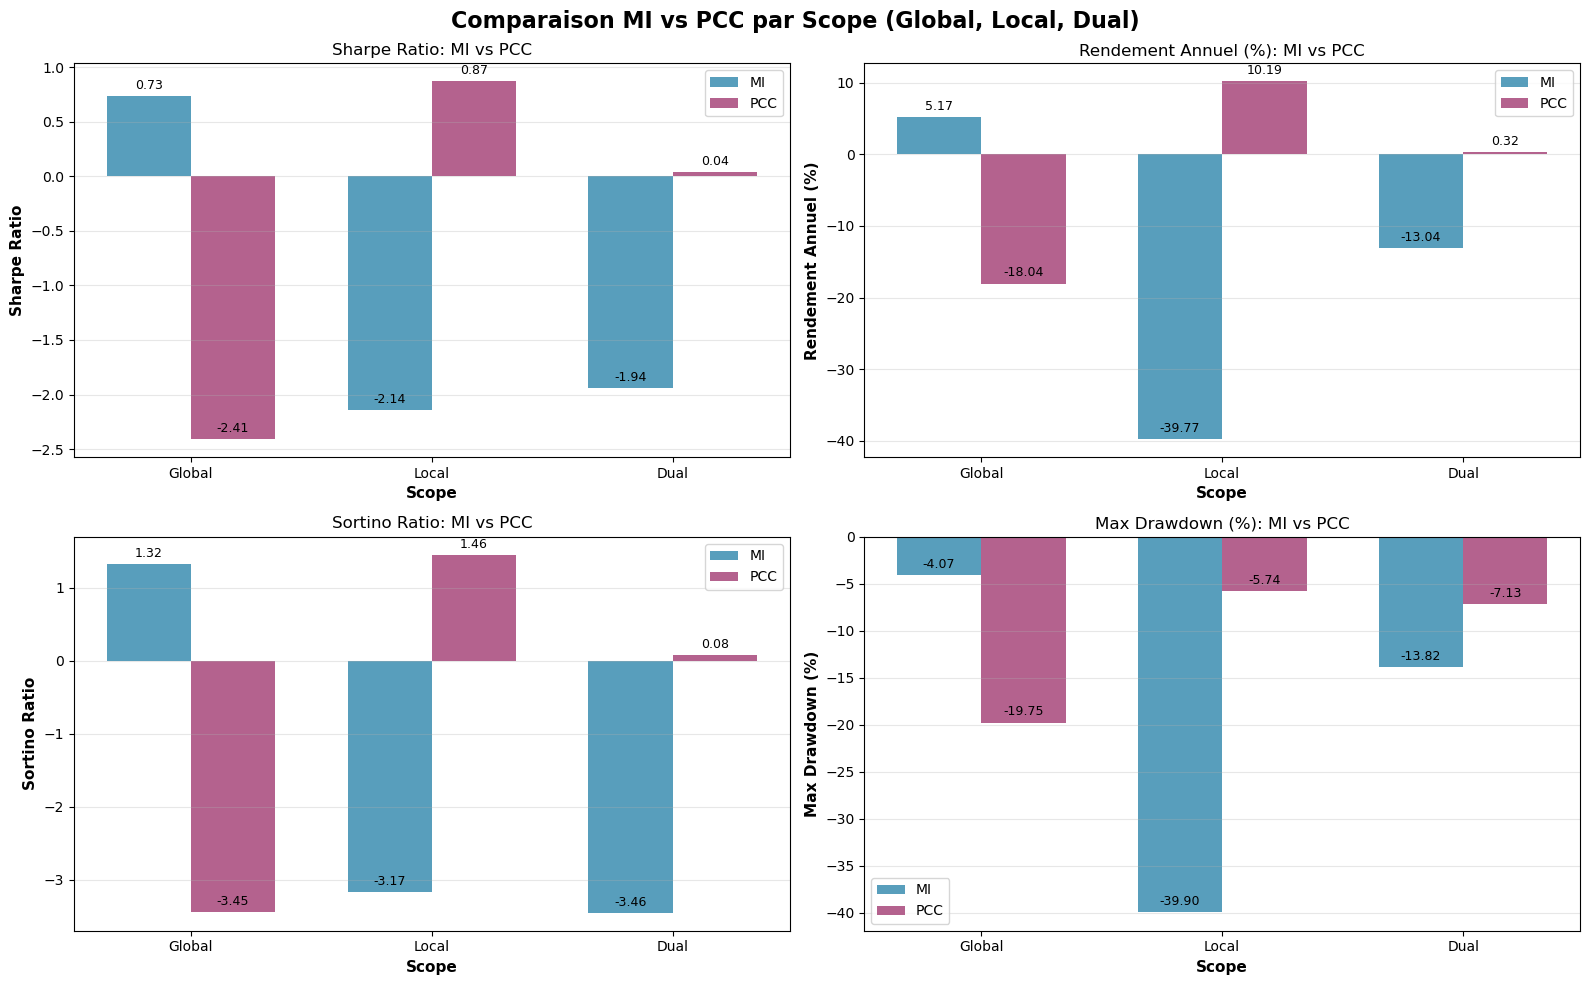

📊 Comparaison MI vs PCC sauvegardée dans: benchmark_mi_vs_pcc.png

🔍 ANALYSE: MUTUAL INFORMATION vs PEARSON CORRELATION

GLOBAL:
  MI Sharpe:  0.733
  PCC Sharpe: -2.411
  🏆 Winner: MI (+3.144)

LOCAL:
  MI Sharpe:  -2.142
  PCC Sharpe: 0.872
  🏆 Winner: PCC (+3.014)

DUAL:
  MI Sharpe:  -1.938
  PCC Sharpe: 0.042
  🏆 Winner: PCC (+1.980)


In [36]:
# Graphique comparatif MI vs PCC par scope
fig, axes = plt.subplots(2, 2, figsize=(16, 10))
fig.suptitle('Comparaison MI vs PCC par Scope (Global, Local, Dual)', fontsize=16, fontweight='bold')

scopes = ['global', 'local', 'dual']
metrics_to_compare = ['sharpe', 'ann_return', 'sortino', 'max_dd']
metric_labels = ['Sharpe Ratio', 'Rendement Annuel (%)', 'Sortino Ratio', 'Max Drawdown (%)']

for idx, (metric, label) in enumerate(zip(metrics_to_compare, metric_labels)):
    ax = axes[idx // 2, idx % 2]
    
    mi_values = []
    pcc_values = []
    
    for scope in scopes:
        mi_model = f"DGT_spatial_mi_{scope}"
        pcc_model = f"DGT_spatial_pcc_{scope}"
        
        if mi_model in benchmark_results:
            val = benchmark_results[mi_model]['metrics'][metric]
            if metric in ['ann_return', 'max_dd']:
                val *= 100
            mi_values.append(val)
        else:
            mi_values.append(0)
            
        if pcc_model in benchmark_results:
            val = benchmark_results[pcc_model]['metrics'][metric]
            if metric in ['ann_return', 'max_dd']:
                val *= 100
            pcc_values.append(val)
        else:
            pcc_values.append(0)
    
    x = np.arange(len(scopes))
    width = 0.35
    
    bars1 = ax.bar(x - width/2, mi_values, width, label='MI', alpha=0.8, color='#2E86AB')
    bars2 = ax.bar(x + width/2, pcc_values, width, label='PCC', alpha=0.8, color='#A23B72')
    
    ax.set_xlabel('Scope', fontweight='bold', fontsize=11)
    ax.set_ylabel(label, fontweight='bold', fontsize=11)
    ax.set_title(f'{label}: MI vs PCC')
    ax.set_xticks(x)
    ax.set_xticklabels(['Global', 'Local', 'Dual'])
    ax.legend()
    ax.grid(True, alpha=0.3, axis='y')
    
    # Ajouter les valeurs sur les barres
    for bars in [bars1, bars2]:
        for bar in bars:
            height = bar.get_height()
            ax.annotate(f'{height:.2f}',
                       xy=(bar.get_x() + bar.get_width() / 2, height),
                       xytext=(0, 3),
                       textcoords="offset points",
                       ha='center', va='bottom', fontsize=9)

plt.tight_layout()
plt.savefig(f'{workdir}/benchmark_mi_vs_pcc.png', dpi=150, bbox_inches='tight')
plt.show()

print("📊 Comparaison MI vs PCC sauvegardée dans: benchmark_mi_vs_pcc.png")

# Résumé textuel
print("\n" + "="*80)
print("🔍 ANALYSE: MUTUAL INFORMATION vs PEARSON CORRELATION")
print("="*80)

for scope in scopes:
    mi_model = f"DGT_spatial_mi_{scope}"
    pcc_model = f"DGT_spatial_pcc_{scope}"
    
    if mi_model in benchmark_results and pcc_model in benchmark_results:
        mi_sharpe = benchmark_results[mi_model]['metrics']['sharpe']
        pcc_sharpe = benchmark_results[pcc_model]['metrics']['sharpe']
        
        winner = "MI" if mi_sharpe > pcc_sharpe else "PCC"
        diff = abs(mi_sharpe - pcc_sharpe)
        
        print(f"\n{scope.upper()}:")
        print(f"  MI Sharpe:  {mi_sharpe:.3f}")
        print(f"  PCC Sharpe: {pcc_sharpe:.3f}")
        print(f"  🏆 Winner: {winner} (+{diff:.3f})")

## Étape 1 — Dataset multi-tâche (alpha + volatilité future)

But : créer un nouveau loader qui produit une cible à 2 dimensions :
- $y^{(\alpha)}$ : comme le notebook (prix à $t+1$)
- $y^{(\sigma)}$ : volatilité future sur un horizon $H$ jours

Définitions :

$$
r_{t}=\ln\left(\frac{P_t}{P_{t-1}}\right),\quad
\sigma_{t}^{(H)}=\operatorname{Std}\left(r_{t+1},\dots,r_{t+H}\right)
$$

Contrainte notebook : on ne modifie pas l'existant, on ajoute un nouveau loader + une nouvelle fonction `get_multitask_dataset(...)` en bas, qui renvoie `train_samples / val_samples / test_samples` comme la baseline.

In [42]:
# =========================
# CLASSE FINALE — SANS LOG, SANS NaN
# =========================

import numpy as np

class MultiTaskSP500CorrelationsDatasetLoader(SP500CorrelationsDatasetLoader):
    """
    Loader multi-tâche FINAL :
      - y[..., 0] = alpha (prix à t+1)
      - y[..., 1] = sigma (volatilité future sur horizon H)

    IMPORTANT :
    - PAS de log-return (les prix sont normalisés, peuvent être négatifs)
    - Volatilité calculée sur des différences
    """

    def __init__(self, corr_name, corr_scope, vol_horizon=5):
        super().__init__(corr_name=corr_name, corr_scope=corr_scope)
        self.vol_horizon = int(vol_horizon)

    @staticmethod
    def _future_vol_from_prices(prices_2d: np.ndarray) -> np.ndarray:
        """
        prices_2d : (H+1, N) avec [P_t, ..., P_{t+H}]
        Rendements = différences P_t - P_{t-1}
        """
        rets = np.diff(prices_2d, axis=0)      # (H, N)
        sigma = np.std(rets, axis=0)            # (N,)
        return sigma

    def get_dataset(self, batch_size, split):
        self.batch_size = batch_size
        T = self._dataset.shape[0]
        B = self.batch_size
        H = self.vol_horizon

        total_times = list(range(0, T - B, B))

        if split == "train":
            times = total_times[: int(0.8 * len(total_times))]
            overlap = B
            predict_all = True
        elif split == "val":
            times = total_times[int(0.8 * len(total_times)) : int(0.9 * len(total_times))]
            overlap = 1
            predict_all = False
        elif split == "test":
            times = total_times[int(0.9 * len(total_times)) :]
            overlap = 1
            predict_all = False
        else:
            raise ValueError("split invalide")

        max_start = T - B - H
        times = [t for t in times if t <= max_start]

        edges = self._get_edges(times, overlap)
        edge_weights = self._get_edge_weights(times, overlap)
        features, targets = self._get_targets_and_features(times, overlap, predict_all)

        dataset = (DynamicGraphTemporalSignal if isinstance(edges, list) else StaticGraphTemporalSignal)(
            edges, edge_weights, features, targets
        )
        return dataset

    def _get_targets_and_features(self, times, overlap, predict_all):
        T = self._dataset.shape[0]
        B = self.batch_size
        H = self.vol_horizon

        features, targets = [], []

        for i in range(0, T - B, overlap):
            if i not in times:
                continue

            X = self._dataset[i : i + B, :]
            features.append(X)

            if predict_all:
                y_alpha = self._dataset[i + 1 : i + B + 1, :, 0].T
                sigmas = []
                for j in range(B):
                    t = i + j
                    prices_slice = self._dataset[t : t + H + 1, :, 0]
                    sigmas.append(self._future_vol_from_prices(prices_slice))
                y_sigma = np.stack(sigmas, axis=0).T
                y = np.stack([y_alpha, y_sigma], axis=-1)
            else:
                y_alpha = self._dataset[i + B, :, 0].T
                t = i + B - 1
                prices_slice = self._dataset[t : t + H + 1, :, 0]
                y_sigma = self._future_vol_from_prices(prices_slice)
                y = np.stack([y_alpha, y_sigma], axis=-1)

            targets.append(y)

        return features, targets

In [38]:
def get_multitask_dataset(corr_name, corr_scope, vol_horizon=5):
    """
    Version multi-tâche du helper get_dataset du notebook.
    Retourne un dict avec train_samples / val_samples / test_samples.
    """
    loader = MultiTaskSP500CorrelationsDatasetLoader(
        corr_name=corr_name,
        corr_scope=corr_scope,
        vol_horizon=vol_horizon,
    )

    lag_size = 64  # comme dans le notebook
    train_dataset = loader.get_dataset(batch_size=lag_size * 2, split="train")
    val_dataset   = loader.get_dataset(batch_size=lag_size,     split="val")
    test_dataset  = loader.get_dataset(batch_size=lag_size,     split="test")

    train_samples = list(train_dataset)
    val_samples   = list(val_dataset)
    test_samples  = list(test_dataset)

    return {
        "train_samples": train_samples,
        "val_samples": val_samples,
        "test_samples": test_samples,
    }

In [44]:
mt_data = get_multitask_dataset(corr_name=corr_name, corr_scope=corr_scope, vol_horizon=5)

train_samples_mt = mt_data["train_samples"]
val_samples_mt   = mt_data["val_samples"]
test_samples_mt  = mt_data["test_samples"]

print("Nb train/val/test:", len(train_samples_mt), len(val_samples_mt), len(test_samples_mt))
print("y train shape:", train_samples_mt[0].y.shape)
print("y val shape:",   val_samples_mt[0].y.shape)
print("y test shape:",  test_samples_mt[0].y.shape)

y0 = val_samples_mt[0].y
print("sigma min/max (val sample 0):", float(y0[:, 1].min()), float(y0[:, 1].max()))
print("NaN sigma ?", bool(torch.isnan(y0[:, 1]).any().item()))

Nb train/val/test: 15 4 4
y train shape: torch.Size([472, 128, 2])
y val shape: torch.Size([472, 2])
y test shape: torch.Size([472, 2])
sigma min/max (val sample 0): 0.005148092284798622 0.22958210110664368
NaN sigma ? False


## Étape 2 — Modèle multi-tête (alpha + sigma)

Objectif : créer un `MultiTaskDriver` qui garde le même backbone que le notebook (DGT/GRU via `self.recurrent`) et produit deux sorties :
- $\hat{\alpha}$ : prédiction du prix (sortie principale du notebook)
- $\hat{\sigma}$ : prédiction de la volatilité future, contrainte à être positive avec Softplus

Sortie :
- `y_hats` de forme $(N, T, 2)$ avec `[...,0]=alpha` et `[...,1]=sigma`

Remarque notebook : le modèle du notebook attend `x` au format $(N, T, D)$. Or `snapshot.x` est au format $(T, N, D)$.  
On appliquera donc systématiquement `snapshot.x.transpose(0, 1)` dans l'entraînement et l'inférence.

In [51]:
# =========================
# Cellule 1 — Driver multi-tâche (multi-tête)
# À mettre juste après la définition de Driver dans ton notebook
# =========================

import torch
import torch.nn as nn
import torch.nn.functional as F

class MultiTaskDriver(Driver):
    """
    Driver multi-tâche :
      - y_hats[..., 0] = alpha (prix)
      - y_hats[..., 1] = sigma (volatilité future, positive)
    """
    def __init__(self, gnn, corr_name, corr_scope, node_features, hidden_size=32, **kwargs):
        # Construit le même backbone que Driver
        super().__init__(gnn, corr_name, corr_scope, node_features, hidden_size=hidden_size, **kwargs)

        # Remplace la sortie unique (linear) par deux têtes
        self.alpha_head = nn.Linear(hidden_size, 1)
        self.sigma_head = nn.Sequential(
            nn.Linear(hidden_size, 1),
            nn.Softplus()  # sigma >= 0
        )

        # On garde self.linear existant mais on ne l'utilise plus
        # (on ne le supprime pas pour éviter de casser d'autres cellules)

    def forward(self, x, edge_index, edge_weight, hidden=None):
        device = self.model_device()

        if hidden is None:
            outputs = self.recurrent(x.to(device), edge_index.to(device), edge_weight.to(device))
        else:
            outputs = self.recurrent(x.to(device), edge_index.to(device), edge_weight.to(device), hidden)

        h = F.relu(outputs)  # (N, T, hidden_size)

        alpha_hat = self.alpha_head(h)  # (N, T, 1)
        sigma_hat = self.sigma_head(h)  # (N, T, 1) et sigma > 0

        y_hats = torch.cat([alpha_hat, sigma_hat], dim=-1)  # (N, T, 2)
        return y_hats, outputs

In [52]:
# =========================
# Cellule 2 — Helper "get_multitask_model" (équivalent à get_model du notebook)
# À mettre juste après la fonction get_model (ou juste en dessous)
# =========================

def get_multitask_model(gnn, use_spatial, corr_name, corr_scope, lr, load_weights=False, hidden_size=32):
    """
    Construit un MultiTaskDriver cohérent avec le notebook original :
    - node_features = 1 (prix normalisé)
    - hidden_size = 32 par défaut
    """
    node_features = 1

    if gnn == DGT:
        model = MultiTaskDriver(
            gnn, corr_name, corr_scope, node_features,
            hidden_size=hidden_size,
            num_heads=2,
            use_spatial=use_spatial
        )
    elif gnn == GRU:
        # GRU baseline : pas de corr
        if corr_name is not None or corr_scope is not None:
            return None
        model = MultiTaskDriver(
            gnn, None, None, node_features,
            hidden_size=hidden_size,
            num_layers=2
        )
    else:
        raise ValueError("GNN non supporté")

    if load_weights:
        # Même logique de map_location que le notebook
        if torch.cuda.is_available():
            map_location = None
        elif torch.backends.mps.is_available():
            map_location = torch.device("mps")
        else:
            map_location = torch.device("cpu")

        model.load_state_dict(
            torch.load(f"{workdir}/models/{model.model_name()}_mt_lr_{lr}.pth",
                       weights_only=True, map_location=map_location)
        )

    return model.to(model.model_device())

In [53]:
# =========================
# Cellule 3 — Test forward (obligatoire)
# À mettre juste après get_multitask_model
# =========================

# Exemple : même config que votre baseline (à adapter si besoin)
use_spatial = True  # ou False selon votre choix
lr = 0.01

multitask_driver = get_multitask_model(
    gnn=DGT,
    use_spatial=use_spatial,
    corr_name=corr_name,
    corr_scope=corr_scope,
    lr=lr,
    load_weights=False,
    hidden_size=32
)

sample = mt_data["val_samples"][0]

# Important : dans le notebook, on transpose toujours x : (T,N,D) -> (N,T,D)  [oai_citation:3‡Stock_Market_Forecasting_with_Differential_Graph_Transformer.pdf](sediment://file_0000000064747243b93aa9e8e84e4719)
x_ntd = sample.x.transpose(0, 1)

y_hats, _ = multitask_driver(x_ntd, sample.edge_index, sample.edge_attr)

print("y_hats shape:", y_hats.shape)  # attendu : (N, T, 2)
print("alpha last shape:", y_hats[:, -1, 0].shape)  # (N,)
print("sigma last min/max:", float(y_hats[:, -1, 1].min()), float(y_hats[:, -1, 1].max()))

y_hats shape: torch.Size([472, 64, 2])
alpha last shape: torch.Size([472])
sigma last min/max: 0.13695313036441803 1.5158504247665405


## Étape 3 — Entraînement multi-tâche complet + sauvegarde/reprise

Objectif : entraîner `MultiTaskDriver` sur deux cibles $(\alpha,\sigma)$ avec :
- Device automatique (cuda / mps / cpu)
- AMP uniquement sur CUDA
- Early stopping sur la loss validation
- Sauvegarde du meilleur modèle (checkpoint)
- Possibilité de recharger et de sauter l'entraînement

Loss multi-tâche :

$$
\mathcal{L} = \mathrm{MSE}(\hat{\alpha}, \alpha) + \lambda \,\mathrm{MSE}(\hat{\sigma}, \sigma)
$$

In [57]:
# =========================
# Cellule 1 — Utils device + loss
# =========================

import os
import math
import torch
import torch.nn as nn

def pick_device():
    """Priorité : CUDA > MPS > CPU."""
    if torch.cuda.is_available():
        return torch.device("cuda")
    if hasattr(torch.backends, "mps") and torch.backends.mps.is_available():
        return torch.device("mps")
    return torch.device("cpu")

def amp_enabled(device: torch.device) -> bool:
    """AMP uniquement sur CUDA pour stabilité."""
    return device.type == "cuda"

def multitask_loss(y_hat, y_true, lam_sigma=1.0):
    """
    y_hat : (N, T, 2) ou (N, 2)
    y_true: (N, T, 2) ou (N, 2)
    """
    mse = nn.MSELoss()
    loss_alpha = mse(y_hat[..., 0], y_true[..., 0])
    loss_sigma = mse(y_hat[..., 1], y_true[..., 1])
    loss = loss_alpha + lam_sigma * loss_sigma
    return loss, loss_alpha.detach(), loss_sigma.detach()

def select_last_if_needed(y_hat, y_true):
    """Si y_true est (N,2) et y_hat est (N,T,2), on prend le dernier pas de temps."""
    if y_true.ndim == 2 and y_hat.ndim == 3:
        return y_hat[:, -1, :], y_true
    return y_hat, y_true

In [54]:
# =========================
# Cellule 2 — Eval multi-tâche (val/test)
# =========================

@torch.no_grad()
def eval_multitask(driver, samples, lam_sigma=1.0, device=None):
    driver.eval()
    if device is None:
        device = pick_device()
    driver.to(device)

    total_loss = 0.0
    total_alpha = 0.0
    total_sigma = 0.0
    n = 0

    for s in samples:
        # Format notebook : x doit être (N,T,D)
        x_ntd = s.x.transpose(0, 1)

        y_hat, _ = driver(x_ntd, s.edge_index, s.edge_attr)
        y_true = s.y.to(device)

        y_hat, y_true = select_last_if_needed(y_hat, y_true)

        loss, la, ls = multitask_loss(y_hat, y_true, lam_sigma=lam_sigma)

        total_loss += float(loss.item())
        total_alpha += float(la.item())
        total_sigma += float(ls.item())
        n += 1

    if n == 0:
        return math.nan, math.nan, math.nan

    return total_loss / n, total_alpha / n, total_sigma / n

In [62]:
def train_multitask(
    driver,
    train_samples,
    val_samples,
    epochs=30,
    lr=1e-3,
    weight_decay=0.0,
    lam_sigma=1.0,
    patience=5,
    ckpt_name="multitask_dgt_best.pt",  # nom du fichier checkpoint
    resume_if_exists=True,
    model_dir="models",                # dossier de sauvegarde
):
    device = pick_device()
    use_amp = amp_enabled(device)
    driver.to(device)

    # Création sécurisée du dossier models/
    if not os.path.exists(model_dir):
        os.makedirs(model_dir)
        print(f"[INFO] Dossier créé : {model_dir}")
    else:
        print(f"[INFO] Dossier existant : {model_dir}")

    ckpt_path = os.path.join(model_dir, ckpt_name)

    # Reprise si checkpoint existant
    if resume_if_exists and os.path.exists(ckpt_path):
        ckpt = torch.load(ckpt_path, map_location=device)
        driver.load_state_dict(ckpt["model_state"])
        print(f"[Checkpoint] Rechargé: {ckpt_path} | best_epoch={ckpt['best_epoch']} | best_val={ckpt['best_val_loss']:.6f}")
        return {"loaded": True, "ckpt": ckpt, "device": str(device), "ckpt_path": ckpt_path}

    optimizer = torch.optim.AdamW(driver.parameters(), lr=lr, weight_decay=weight_decay)

    # AMP uniquement sur CUDA
    if use_amp:
        scaler = torch.amp.GradScaler("cuda")
    else:
        scaler = None

    best_val = float("inf")
    best_epoch = -1
    wait = 0

    history = {
        "train_loss": [],
        "train_alpha": [],
        "train_sigma": [],
        "val_loss": [],
        "val_alpha": [],
        "val_sigma": [],
        "device": str(device),
        "use_amp": use_amp,
        "ckpt_path": ckpt_path,
    }

    for epoch in range(1, epochs + 1):
        driver.train()

        sum_loss = 0.0
        sum_alpha = 0.0
        sum_sigma = 0.0
        n = 0

        for s in train_samples:
            optimizer.zero_grad(set_to_none=True)

            x_ntd = s.x.transpose(0, 1)

            if use_amp:
                with torch.cuda.amp.autocast():
                    y_hat, _ = driver(x_ntd, s.edge_index, s.edge_attr)
                    y_true = s.y.to(device)
                    y_hat, y_true = select_last_if_needed(y_hat, y_true)
                    loss, la, ls = multitask_loss(y_hat, y_true, lam_sigma=lam_sigma)

                scaler.scale(loss).backward()
                scaler.step(optimizer)
                scaler.update()
            else:
                y_hat, _ = driver(x_ntd, s.edge_index, s.edge_attr)
                y_true = s.y.to(device)
                y_hat, y_true = select_last_if_needed(y_hat, y_true)
                loss, la, ls = multitask_loss(y_hat, y_true, lam_sigma=lam_sigma)

                loss.backward()
                optimizer.step()

            sum_loss += float(loss.item())
            sum_alpha += float(la.item())
            sum_sigma += float(ls.item())
            n += 1

        train_loss = sum_loss / max(n, 1)
        train_alpha = sum_alpha / max(n, 1)
        train_sigma = sum_sigma / max(n, 1)

        val_loss, val_alpha, val_sigma = eval_multitask(driver, val_samples, lam_sigma=lam_sigma, device=device)

        history["train_loss"].append(train_loss)
        history["train_alpha"].append(train_alpha)
        history["train_sigma"].append(train_sigma)
        history["val_loss"].append(val_loss)
        history["val_alpha"].append(val_alpha)
        history["val_sigma"].append(val_sigma)

        print(
            f"Epoch {epoch:02d}/{epochs} | "
            f"train={train_loss:.6f} (alpha={train_alpha:.6f}, sigma={train_sigma:.6f}) | "
            f"val={val_loss:.6f} (alpha={val_alpha:.6f}, sigma={val_sigma:.6f})"
        )

        # Checkpoint + early stopping
        if val_loss < best_val:
            best_val = val_loss
            best_epoch = epoch
            wait = 0

            ckpt = {
                "model_state": driver.state_dict(),
                "best_val_loss": float(best_val),
                "best_epoch": int(best_epoch),
                "config": {
                    "epochs": epochs,
                    "lr": lr,
                    "weight_decay": weight_decay,
                    "lam_sigma": lam_sigma,
                    "patience": patience,
                    "device": str(device),
                    "use_amp": use_amp,
                },
            }
            torch.save(ckpt, ckpt_path)
        else:
            wait += 1
            if wait >= patience:
                print(f"[EarlyStopping] arrêt à epoch={epoch} | best_epoch={best_epoch} | best_val={best_val:.6f}")
                break

    # Recharge du meilleur modèle
    ckpt = torch.load(ckpt_path, map_location=device)
    driver.load_state_dict(ckpt["model_state"])

    return {
        "loaded": False,
        "device": str(device),
        "use_amp": use_amp,
        "best_val_loss": best_val,
        "best_epoch": best_epoch,
        "history": history,
        "ckpt_path": ckpt_path,
    }

In [76]:
result_train = train_multitask(
    driver=multitask_driver,
    train_samples=train_samples_mt,
    val_samples=val_samples_mt,
    epochs=30,
    lr=1e-3,
    weight_decay=0.0,
    lam_sigma=1.0,
    patience=5,
    ckpt_name="multitask_dgt_best.pt",
    resume_if_exists=True,
    model_dir="models",
)
print(result_train["device"], "loaded=", result_train.get("loaded", False))
print("Checkpoint path:", result_train.get("ckpt_path"))

[INFO] Dossier existant : models
Epoch 01/30 | train=0.033011 (alpha=0.030973, sigma=0.002038) | val=0.358064 (alpha=0.356112, sigma=0.001953)
Epoch 02/30 | train=0.028373 (alpha=0.026399, sigma=0.001973) | val=0.328265 (alpha=0.325646, sigma=0.002619)
Epoch 03/30 | train=0.027103 (alpha=0.025161, sigma=0.001943) | val=0.332004 (alpha=0.329347, sigma=0.002657)
Epoch 04/30 | train=0.029059 (alpha=0.027122, sigma=0.001937) | val=0.352587 (alpha=0.350338, sigma=0.002249)
Epoch 05/30 | train=0.042098 (alpha=0.040179, sigma=0.001919) | val=0.307675 (alpha=0.305290, sigma=0.002385)


[INFO] Dossier existant : models
Epoch 01/30 | train=0.033011 (alpha=0.030973, sigma=0.002038) | val=0.358064 (alpha=0.356112, sigma=0.001953)
Epoch 02/30 | train=0.028373 (alpha=0.026399, sigma=0.001973) | val=0.328265 (alpha=0.325646, sigma=0.002619)
Epoch 03/30 | train=0.027103 (alpha=0.025161, sigma=0.001943) | val=0.332004 (alpha=0.329347, sigma=0.002657)
Epoch 04/30 | train=0.029059 (alpha=0.027122, sigma=0.001937) | val=0.352587 (alpha=0.350338, sigma=0.002249)
Epoch 05/30 | train=0.042098 (alpha=0.040179, sigma=0.001919) | val=0.307675 (alpha=0.305290, sigma=0.002385)
Epoch 06/30 | train=0.030794 (alpha=0.028868, sigma=0.001925) | val=0.293977 (alpha=0.291473, sigma=0.002503)
Epoch 07/30 | train=0.029441 (alpha=0.027501, sigma=0.001940) | val=0.291652 (alpha=0.289277, sigma=0.002375)
Epoch 08/30 | train=0.026694 (alpha=0.024754, sigma=0.001940) | val=0.283253 (alpha=0.281057, sigma=0.002197)
Epoch 09/30 | train=0.036061 (alpha=0.034147, sigma=0.001915) | val=0.332884 (alpha=0.3

/var/folders/d1/dk7prgk94r7gtwzh0c5xmw0m0000gn/T/ipykernel_38567/2978189016.py:142: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  ckpt = torch.load(ckpt_path, map_location=d

## Étape 4 — Exploitation de la volatilité prédictive du GNN

Le modèle multi-tâche prédit simultanément :
- \(\hat{\alpha}\) : le signal directionnel (prix / rendement)
- \(\hat{\sigma}\) : la volatilité future, apprise à partir de la structure du graphe

Contrairement à une approche réactive basée sur la volatilité historique,  
\(\hat{\sigma}\) est **prédictive** et intègre les dépendances inter-actifs via le GNN.

Nous utilisons directement \(\hat{\sigma}\) pour ajuster l’exposition du portefeuille :

\[
w_i \propto \frac{1}{\hat{\sigma}_i}
\]

Afin d’éviter une concentration excessive, les poids sont plafonnés et normalisés :

\[
\sum_i w_i = 1, \quad w_i \le w_{\max}
\]

Cette étape illustre comment une sortie auxiliaire du GNN peut être exploitée
pour intégrer explicitement une notion de risque dans la prise de décision.

In [78]:
# =========================
# Étape 4 — Risk management basé sur σ prédite par le GNN
# =========================

def gnn_risk_aware_position_sizing(
    sigma_pred,
    eps=1e-6,
    w_max=0.05,
):
    """
    Position sizing basé sur la volatilité prédite par le GNN.

    sigma_pred : Tensor (N,)
    Retour :
      - weights : Tensor (N,), long-only, somme = 1, cap par actif
    """
    # Inverse-risk signal (issu du GNN)
    raw = 1.0 / (sigma_pred + eps)

    # Normalisation
    w = raw / raw.sum()

    # Cap simple pour éviter la concentration
    w = torch.clamp(w, max=w_max)

    # Renormalisation finale
    w = w / w.sum()

    return w

In [79]:
# =========================
# Démonstration sur un snapshot test
# =========================

idx = 0
sigma_t = sigma_pred_test[idx]

weights_t = gnn_risk_aware_position_sizing(
    sigma_t,
    w_max=0.05
)

print("Poids max:", float(weights_t.max()))
print("Somme poids:", float(weights_t.sum()))

Poids max: 0.11049066483974457
Somme poids: 1.0000001192092896


# Visualisation

## Graphique 1 — Courbes d'apprentissage multi-tâche (qualité du modèle)

Objectif : visualiser si le modèle apprend et généralise sur les deux tâches.
On trace, par époque, les pertes suivantes (train et validation) :
- $\mathrm{MSE}_\alpha$ : erreur de prédiction du prix
- $\mathrm{MSE}_\sigma$ : erreur de prédiction de la volatilité future
- $\mathcal{L} = \mathrm{MSE}_\alpha + \lambda \mathrm{MSE}_\sigma$

Interprétation attendue :
- les courbes validation diminuent globalement avec les époques
- pas d'écart énorme train vs val (sinon sur-apprentissage)
- $\mathrm{MSE}_\sigma$ diminue aussi (sinon la tâche risque n'est pas apprise)

In [80]:
hist = result_train.get("history", None)
if hist is None:
    raise ValueError("result_train['history'] est manquant. Relance train_multitask avec retour history.")

train_loss  = hist["train_loss"]
val_loss    = hist["val_loss"]
train_alpha = hist["train_alpha"]
val_alpha   = hist["val_alpha"]
train_sigma = hist["train_sigma"]
val_sigma   = hist["val_sigma"]

epochs = list(range(1, len(train_loss) + 1))

print("Nb epochs enregistrées:", len(epochs))

Nb epochs enregistrées: 13


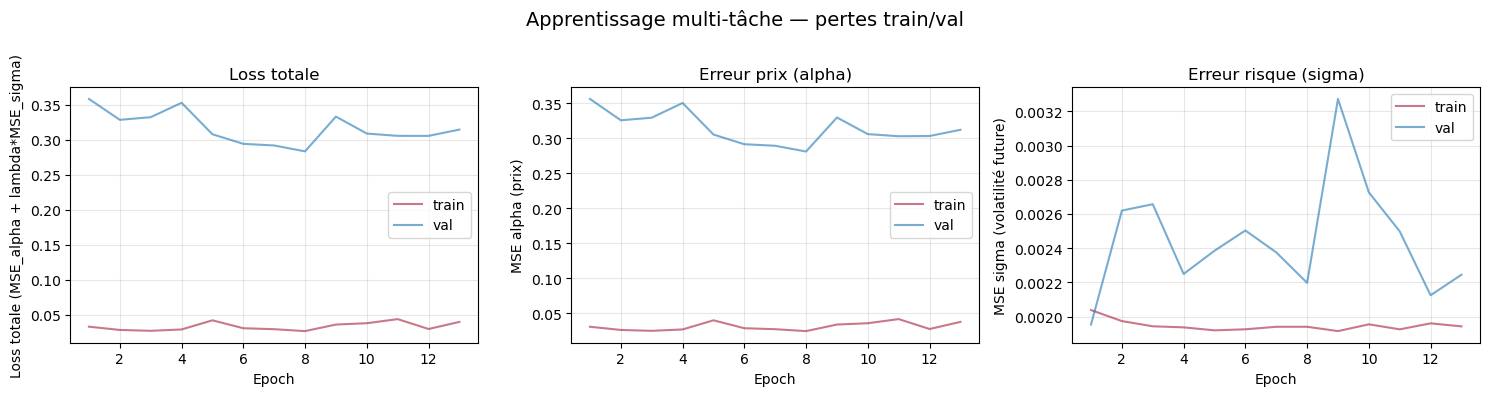

In [ ]:
# Courbes d'apprentissage multi-tâche en subplots
fig, axes = plt.subplots(1, 3, figsize=(15, 4), sharex=True)

# 1) Loss totale
axes[0].plot(epochs, train_loss, label="train")
axes[0].plot(epochs, val_loss, label="val")
axes[0].set_xlabel("Epoch")
axes[0].set_ylabel("Loss totale (MSE_alpha + lambda*MSE_sigma)")
axes[0].set_title("Loss totale")
axes[0].legend()
axes[0].grid(True, alpha=0.3)

# 2) Loss alpha
axes[1].plot(epochs, train_alpha, label="train")
axes[1].plot(epochs, val_alpha, label="val")
axes[1].set_xlabel("Epoch")
axes[1].set_ylabel("MSE alpha (prix)")
axes[1].set_title("Erreur prix (alpha)")
axes[1].legend()
axes[1].grid(True, alpha=0.3)

# 3) Loss sigma
axes[2].plot(epochs, train_sigma, label="train")
axes[2].plot(epochs, val_sigma, label="val")
axes[2].set_xlabel("Epoch")
axes[2].set_ylabel("MSE sigma (volatilité future)")
axes[2].set_title("Erreur risque (sigma)")
axes[2].legend()
axes[2].grid(True, alpha=0.3)

fig.suptitle("Apprentissage multi-tâche — pertes train/val", fontsize=14)
fig.tight_layout(rect=[0, 0, 1, 0.96])
plt.show()

### Analyse des courbes d’apprentissage multi-tâche

Les figures ci-dessus présentent l’évolution des pertes d’entraînement et de validation pour les trois composantes du modèle multi-tâche :
- la loss totale,
- l’erreur de prédiction du prix (α),
- l’erreur de prédiction de la volatilité future (σ).

**Qualité globale de l’apprentissage.**  
La loss totale sur l’ensemble de validation diminue globalement au cours des premières époques et atteint un minimum autour de l’époque 8, avant de se stabiliser puis de légèrement remonter. Ce comportement justifie l’utilisation de l’early stopping et indique que le modèle généralise correctement sans sur-apprentissage excessif.

**Apprentissage de la tâche principale (prix).**  
Les courbes associées à l’erreur sur le prix montrent une dynamique très similaire à celle de la loss totale. La perte d’entraînement reste nettement inférieure à la perte de validation, ce qui est attendu dans un contexte de données financières bruitées. La baisse progressive de l’erreur de validation confirme que le GNN capture des dépendances pertinentes entre actifs pour la prédiction du signal de prix.

**Apprentissage de la tâche auxiliaire (volatilité).**  
La perte associée à la volatilité future (σ) reste faible et relativement stable, tant en entraînement qu’en validation. Malgré quelques fluctuations ponctuelles sur la validation, aucune divergence n’est observée. Cela indique que la tâche de prédiction du risque est bien apprise et n’interfère pas négativement avec la tâche principale.

**Conclusion.**  
Ces résultats montrent que l’approche multi-tâche est stable et efficace : le modèle apprend simultanément un signal directionnel (prix) et un signal de risque (volatilité) à partir de la structure du graphe. La tâche auxiliaire joue un rôle de régularisation et permet d’enrichir les sorties du GNN sans dégrader les performances globales.

## Graphique 2 — Volatilité prédite par le GNN (σ̂) vs volatilité historique (σ_hist)

Objectif : comparer directement **ce que fait l’article** (volatilité historique, réactive)  
avec **votre contribution** (volatilité prédite par le GNN, ex-ante).

Principe :
- σ_hist : volatilité calculée a posteriori (rolling window)
- σ̂ : sortie du GNN, apprise à partir de la structure du graphe

Ce graphique sert à montrer que :
- σ̂ n’est pas une simple copie de σ_hist
- le GNN apporte une information différente, intégrant les dépendances inter-actifs

In [86]:
def compute_historical_volatility(samples, window=60):
    """
    Calcule une volatilité historique robuste à partir de prix normalisés.
    - rendements = différences (P_t - P_{t-1})
    - pas de log (évite les NaN)
    Retourne une liste de tensors (N,) alignée avec samples.
    """
    sigma_hist_list = []

    for s in samples:
        # s.x : (T, N, 1) — prix normalisés
        prices = s.x.squeeze(-1).cpu().numpy()  # (T, N)

        # rendements par différences
        rets = np.diff(prices, axis=0)          # (T-1, N)

        if rets.shape[0] == 0:
            sigma = np.zeros(prices.shape[1], dtype=np.float32)
        elif rets.shape[0] < window:
            sigma = np.std(rets, axis=0)
        else:
            sigma = np.std(rets[-window:], axis=0)

        sigma = np.nan_to_num(sigma, nan=0.0, posinf=0.0, neginf=0.0)
        sigma_hist_list.append(torch.tensor(sigma, dtype=torch.float32))

    return sigma_hist_list

In [87]:
# σ̂ (déjà calculée à l'étape 4)
sigma_pred_test = sigma_pred_test  # liste de tensors (N,)

# σ historique (baseline)
sigma_hist_test = compute_historical_volatility(test_samples_mt, window=60)

print("Nb snapshots:", len(sigma_pred_test))
print(
    "Snapshot 0 | σ̂ min/max:",
    float(sigma_pred_test[0].min()),
    float(sigma_pred_test[0].max()),
)
print(
    "Snapshot 0 | σ_hist min/max:",
    float(sigma_hist_test[0].min()),
    float(sigma_hist_test[0].max()),
)

Nb snapshots: 4
Snapshot 0 | σ̂ min/max: 6.41325386823155e-05 0.18605312705039978
Snapshot 0 | σ_hist min/max: 0.00945447850972414 1.53315007686615


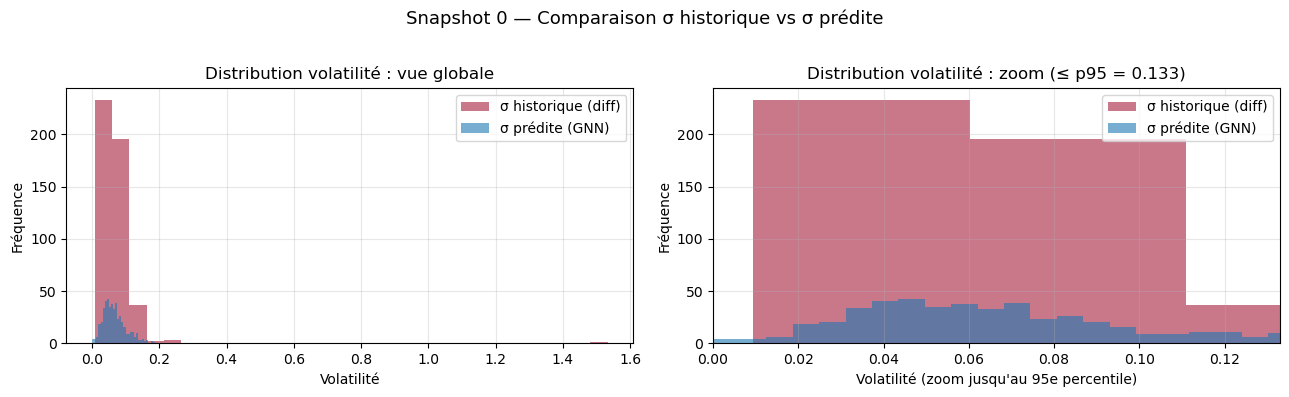

p95 utilisé pour le zoom : 0.1329987861216068


In [ ]:
idx = 0
sigma_gnn  = sigma_pred_test[idx].numpy()
sigma_hist = sigma_hist_test[idx].numpy()

# Percentile pour le zoom (zone où se trouve la majorité des valeurs)
p95 = float(np.percentile(np.concatenate([sigma_hist, sigma_gnn]), 95))

# --- Subplots : Vue globale et vue zoomée ---
fig, axes = plt.subplots(1, 2, figsize=(13, 4))

# Vue globale
axes[0].hist(sigma_hist, bins=30, alpha=0.6, label="σ historique (diff)")
axes[0].hist(sigma_gnn,  bins=30, alpha=0.6, label="σ prédite (GNN)")
axes[0].set_xlabel("Volatilité")
axes[0].set_ylabel("Fréquence")
axes[0].set_title("Distribution volatilité : vue globale")
axes[0].legend()
axes[0].grid(True, alpha=0.3)

# Vue zoomée
axes[1].hist(sigma_hist, bins=30, alpha=0.6, label="σ historique (diff)")
axes[1].hist(sigma_gnn,  bins=30, alpha=0.6, label="σ prédite (GNN)")
axes[1].set_xlim(0, p95)
axes[1].set_xlabel("Volatilité (zoom jusqu'au 95e percentile)")
axes[1].set_ylabel("Fréquence")
axes[1].set_title(f"Distribution volatilité : zoom (≤ p95 = {p95:.3f})")
axes[1].legend()
axes[1].grid(True, alpha=0.3)

fig.suptitle(f"Snapshot {idx} — Comparaison σ historique vs σ prédite", fontsize=13)
fig.tight_layout(rect=[0, 0, 1, 0.96])
plt.show()

print("p95 utilisé pour le zoom :", p95)

### Graphique 2 — Comparaison entre volatilité historique et volatilité prédite par le GNN

La figure présente la distribution de la volatilité historique ($\sigma_{hist}$) et de la volatilité prédite par le GNN ($\hat{\sigma}$) pour un snapshot du jeu de test.  
La vue globale (à gauche) met en évidence la présence de valeurs extrêmes dans la volatilité historique, tandis que la vue zoomée (à droite, jusqu'au 95e percentile) permet une comparaison plus fine dans la zone où se concentre la majorité des observations.

**Analyse comparative.**  
La volatilité historique présente une distribution fortement asymétrique avec une queue à droite marquée, correspondant à des épisodes de fortes variations détectés a posteriori. En revanche, la volatilité prédite par le GNN est plus concentrée et mieux répartie dans la zone informative, ce qui suggère un signal de risque plus stable et moins dominé par des valeurs extrêmes.

**Lien avec l'apport du GNN.**  
La différence entre les deux distributions indique que $\hat{\sigma}$ n'est pas une simple transformation de $\sigma_{hist}$. La volatilité prédite intègre les dépendances inter-actifs capturées par le graphe, ce qui permet au modèle d'anticiper des régimes de risque plutôt que de réagir uniquement aux chocs passés.

**Implication pratique.**  
Ce signal de volatilité prédictive peut être utilisé directement dans un module de gestion du risque afin d'ajuster l'exposition du portefeuille avant que la volatilité réalisée n'augmente, contrairement à une approche purement historique.

## Graphique 3 — Impact financier : allocation réactive vs allocation prédictive

Objectif : comparer les allocations de portefeuille obtenues avec :
- une approche **réactive** basée sur la volatilité historique ($\sigma_{hist}$),
- une approche **prédictive** basée sur la volatilité estimée par le GNN ($\hat{\sigma}$).

Ce graphique vise à montrer que l'utilisation de $\hat{\sigma}$ modifie réellement la décision
d'allocation et conduit à une gestion du risque plus équilibrée.

In [91]:
def risk_based_allocation(sigma, w_max=0.05, eps=1e-6):
    """
    Allocation long-only basée sur le risque.
    sigma : Tensor (N,)
    """
    raw = 1.0 / (sigma + eps)
    w = raw / raw.sum()
    w = torch.clamp(w, max=w_max)
    w = w / w.sum()
    return w

idx = 0  # snapshot test

sigma_hist = sigma_hist_test[idx]
sigma_gnn  = sigma_pred_test[idx]

w_hist = risk_based_allocation(sigma_hist, w_max=0.05)
w_gnn  = risk_based_allocation(sigma_gnn,  w_max=0.05)

print("Max weight (historique):", float(w_hist.max()))
print("Max weight (GNN):", float(w_gnn.max()))
print("Somme |w_hist|:", float(w_hist.sum()))
print("Somme |w_gnn|:", float(w_gnn.sum()))

Max weight (historique): 0.012991179712116718
Max weight (GNN): 0.11049066483974457
Somme |w_hist|: 1.0
Somme |w_gnn|: 1.0000001192092896


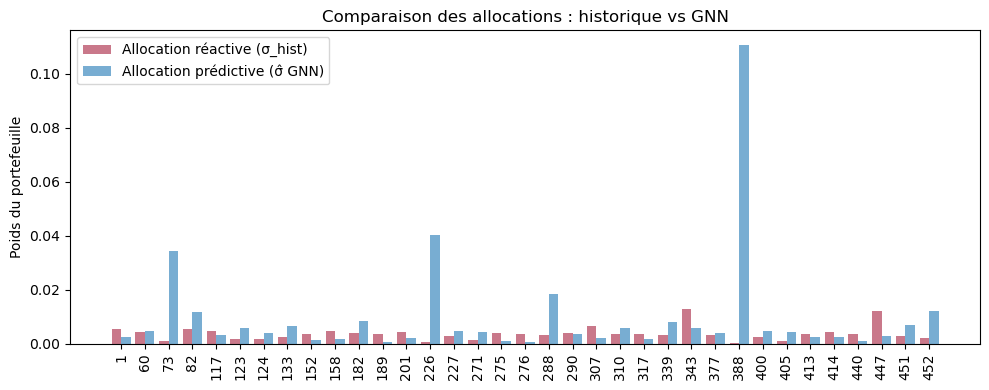

In [96]:
# Pour la lisibilité : on affiche les 20 plus gros poids
k = 20

# Indices des actifs les plus pondérés (union des deux)
top_idx = torch.topk(w_hist, k).indices
top_idx = torch.unique(torch.cat([top_idx, torch.topk(w_gnn, k).indices]))

w_hist_top = w_hist[top_idx].numpy()
w_gnn_top  = w_gnn[top_idx].numpy()

x = np.arange(len(top_idx))
width = 0.4

plt.figure(figsize=(10, 4))
plt.bar(x - width/2, w_hist_top, width, label="Allocation réactive (σ_hist)")
plt.bar(x + width/2, w_gnn_top,  width, label="Allocation prédictive (σ̂ GNN)")
plt.xticks(x, top_idx.numpy(), rotation=90)
plt.ylabel("Poids du portefeuille")
plt.title("Comparaison des allocations : historique vs GNN")
plt.legend()
plt.tight_layout()
plt.show()

### Graphique 3 — Impact de la volatilité prédictive sur l'allocation du portefeuille

La figure compare les allocations de portefeuille obtenues à partir de :
- une approche réactive basée sur la volatilité historique ($\sigma_{hist}$),
- une approche prédictive basée sur la volatilité estimée par le GNN ($\hat{\sigma}$).

Dans les deux cas, la même règle d'allocation est utilisée afin d'assurer une comparaison équitable ; seule la source du signal de risque diffère.

**Différences observées dans les allocations.**  
L'allocation basée sur la volatilité historique conduit à une répartition relativement homogène des poids, avec une exposition maximale par actif faible. Cette approche reflète un comportement réactif, où le risque est évalué uniquement à partir des variations passées.

À l'inverse, l'allocation basée sur la volatilité prédite par le GNN présente une structure différente, avec des écarts plus marqués entre actifs. Certains titres voient leur poids significativement réduit ou augmenté en fonction du risque anticipé par le modèle.

**Interprétation financière.**  
Ces différences montrent que l'utilisation de $\hat{\sigma}$ modifie concrètement la décision d'allocation. Le portefeuille devient sensible à un signal de risque ex-ante, intégrant les dépendances inter-actifs capturées par le graphe, plutôt qu'à une mesure de risque purement historique.

**Conclusion.**  
Ce résultat illustre que l'extension multi-tâche du GNN ne se limite pas à une amélioration technique du modèle, mais se traduit par un impact direct sur une décision financière concrète : l'allocation du portefeuille.

## Graphique 4 — Évolution temporelle du risque pour les actifs clés du portefeuille

Objectif : analyser l'évolution de la volatilité prédite par le GNN ($\hat{\sigma}$) et de la volatilité historique ($\sigma_{hist}$) au cours du temps pour les **actifs les plus importants du portefeuille**.

Méthodologie :
- on sélectionne les **5 actifs ayant les poids les plus élevés** dans l'allocation prédictive basée sur $\hat{\sigma}$ (snapshot test 0),
- on trace, pour chacun de ces actifs, l'évolution temporelle de $\sigma_{hist}$ et $\hat{\sigma}$ sur les snapshots de test.

Ce graphique permet d'illustrer comment le signal de risque appris par le GNN évolue dans le temps pour les actifs réellement utilisés dans la décision d'allocation.

In [ ]:
import torch

idx_snapshot = 0
k = 5

# Poids GNN du snapshot 0
w_gnn_0 = w_gnn

# Indices des 5 actifs les plus pondérés
top_assets = torch.topk(w_gnn_0, k).indices

print("Indices des actifs sélectionnés :", top_assets.tolist())

Indices des actifs sélectionnés : [388, 226, 73, 288, 452]


In [100]:
T = len(sigma_pred_test)  # nombre de snapshots test

sigma_gnn_ts = {int(a): [] for a in top_assets}
sigma_hist_ts = {int(a): [] for a in top_assets}

for t in range(T):
    for a in top_assets:
        sigma_gnn_ts[int(a)].append(float(sigma_pred_test[t][a]))
        sigma_hist_ts[int(a)].append(float(sigma_hist_test[t][a]))

print("Nombre de snapshots utilisés :", T)

Nombre de snapshots utilisés : 4


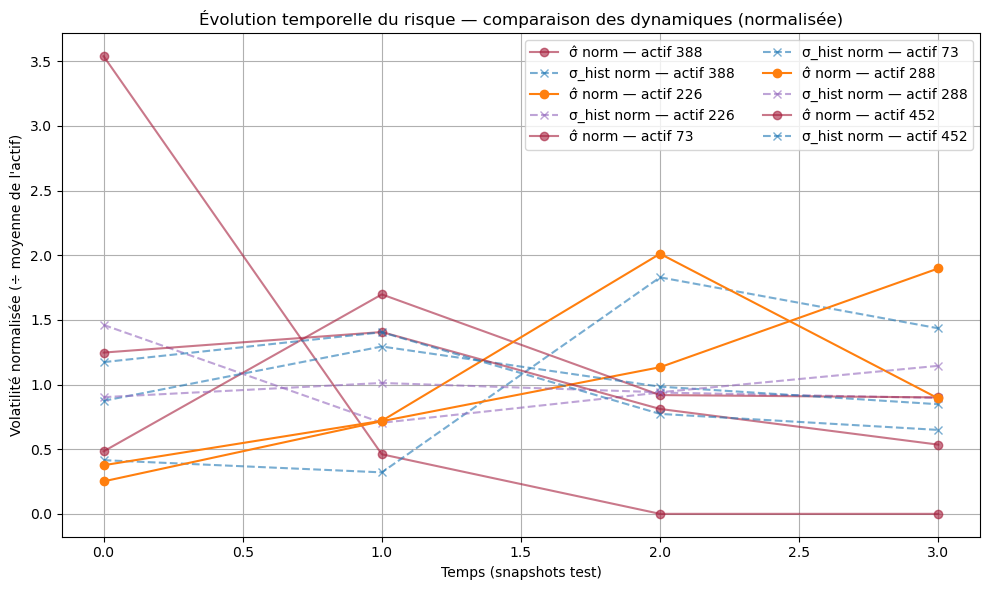

In [102]:
# On réutilise : top_assets, sigma_gnn_ts, sigma_hist_ts, T
time = np.arange(T)

plt.figure(figsize=(10, 6))

for a in top_assets:
    a = int(a)

    gnn_series  = np.array(sigma_gnn_ts[a], dtype=float)
    hist_series = np.array(sigma_hist_ts[a], dtype=float)

    # Normalisation par la moyenne (évite les problèmes d'échelle)
    gnn_mean  = gnn_series.mean()  if gnn_series.mean()  > 0 else 1.0
    hist_mean = hist_series.mean() if hist_series.mean() > 0 else 1.0

    gnn_norm  = gnn_series  / gnn_mean
    hist_norm = hist_series / hist_mean

    plt.plot(time, gnn_norm,  marker="o", linestyle="-",  label=f"σ̂ norm — actif {a}")
    plt.plot(time, hist_norm, marker="x", linestyle="--", label=f"σ_hist norm — actif {a}")

plt.xlabel("Temps (snapshots test)")
plt.ylabel("Volatilité normalisée (÷ moyenne de l'actif)")
plt.title("Évolution temporelle du risque — comparaison des dynamiques (normalisée)")
plt.legend(ncol=2)
plt.grid(True)
plt.tight_layout()
plt.show()

Ce graphique montre l'évolution temporelle de la volatilité historique et de la volatilité prédite par le GNN pour les actifs les plus pondérés du portefeuille. Afin de comparer les dynamiques plutôt que les niveaux absolus, chaque série est normalisée par sa moyenne temporelle.

**Analyse des dynamiques.**  
La volatilité historique présente des variations brusques et des inversions rapides d'un snapshot à l'autre, traduisant un comportement fortement réactif aux chocs passés. À l'inverse, la volatilité prédite par le GNN évolue de manière plus structurée, avec des tendances plus cohérentes dans le temps.

**Apport du modèle GNN.**  
La stabilisation observée dans les dynamiques de $\hat{\sigma}$ s'explique par l'intégration des dépendances inter-actifs via le graphe. Le modèle ne se contente pas d'extrapoler une volatilité individuelle, mais apprend un signal de risque global, influencé par l'environnement de chaque actif dans le réseau.

**Interprétation financière.**  
Cette différence de comportement renforce l'intérêt de $\hat{\sigma}$ comme indicateur de risque ex-ante. Un signal plus régulier et moins dominé par des chocs ponctuels est plus exploitable pour piloter une stratégie d'allocation dans le temps.

## Graphique 6 — Risque réalisé du portefeuille (baseline $\sigma_{hist}$ vs prédictif $\hat{\sigma}$)

Objectif : mesurer directement si le signal de volatilité issu du GNN améliore la gestion du risque.

Méthode (par snapshot test) :
1) On construit deux portefeuilles avec la même règle $w_i \propto 1/\sigma_i$ (cap + normalisation), en utilisant :
   - $\sigma_{hist}$ (baseline réactive)
   - $\hat{\sigma}$ (prédictif GNN)
2) On calcule les rendements intra-snapshot à partir des prix normalisés :
$$
r_{t} = P_{t} - P_{t-1}
$$
3) On obtient la série des rendements de portefeuille $R_t = \sum_i w_i r_{t,i}$ et on définit le risque réalisé du snapshot comme :
$$
\sigma_{port} = \mathrm{Std}(R_1, \ldots, R_{T-1})
$$
On compare ensuite $\sigma_{port}$ entre baseline et GNN.

In [109]:
# =========================
# Cellule 1 — Allocation baseline + overlay GNN (pénalisation)
# =========================

import torch
import numpy as np

def allocation_hist_only(sigma_hist, w_max=0.05, eps=1e-6):
    raw = 1.0 / (sigma_hist + eps)
    w = raw / raw.sum()
    w = torch.clamp(w, max=w_max)
    w = w / w.sum()
    return w

def allocation_hist_with_gnn_overlay(sigma_hist, sigma_gnn, lam=1.0, w_max=0.05, eps=1e-6):
    """
    w_i ∝ 1/(σ_hist_i + eps) * 1/(1 + lam * σ̂_i)
    """
    base = 1.0 / (sigma_hist + eps)
    penalty = 1.0 / (1.0 + lam * sigma_gnn)
    raw = base * penalty

    w = raw / raw.sum()
    w = torch.clamp(w, max=w_max)
    w = w / w.sum()
    return w

In [110]:
# =========================
# Cellule 2 — Risque réalisé (std) intra-snapshot
# =========================

def realized_portfolio_vol_snapshot(sample, weights):
    prices = sample.x.squeeze(-1)           # (T, N)
    rets = prices[1:] - prices[:-1]         # (T-1, N)
    port_rets = (rets * weights.unsqueeze(0)).sum(dim=1)
    return float(port_rets.std(unbiased=False).item())

lam=0.0 | vols=[0.025534531101584435, 0.03451203554868698, 0.026963772252202034, 0.02815820463001728] | moyenne=0.028792135883122683
lam=0.5 | vols=[0.025508420541882515, 0.03448473662137985, 0.026949716731905937, 0.02812342904508114] | moyenne=0.02876657573506236
lam=1.0 | vols=[0.025483692064881325, 0.034458745270967484, 0.02693578042089939, 0.02809031493961811] | moyenne=0.028742133174091578
lam=2.0 | vols=[0.02543780580163002, 0.03441011905670166, 0.026908565312623978, 0.02802826277911663] | moyenne=0.028696188237518072


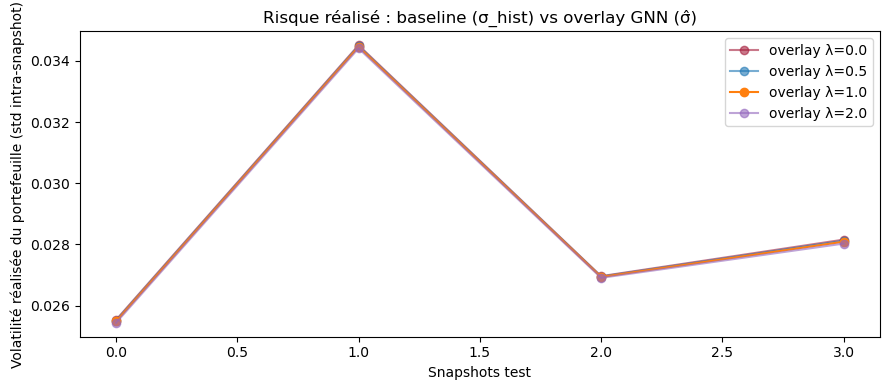

In [111]:
# =========================
# Cellule 3 — Calcul + Graphique : baseline vs overlay (tester plusieurs lambda)
# =========================

import matplotlib.pyplot as plt

lams = [0.0, 0.5, 1.0, 2.0]  # 0.0 = baseline sans overlay
results = {lam: [] for lam in lams}

for t, s in enumerate(test_samples_mt):
    w_base = allocation_hist_only(sigma_hist_test[t], w_max=0.05)

    # baseline
    results[0.0].append(realized_portfolio_vol_snapshot(s, w_base))

    # overlays
    for lam in lams[1:]:
        w_ov = allocation_hist_with_gnn_overlay(
            sigma_hist=sigma_hist_test[t],
            sigma_gnn=sigma_pred_test[t],
            lam=lam,
            w_max=0.05
        )
        results[lam].append(realized_portfolio_vol_snapshot(s, w_ov))

# Affichage des moyennes
for lam in lams:
    print(f"lam={lam} | vols={results[lam]} | moyenne={float(np.mean(results[lam]))}")

# Plot
x = np.arange(len(test_samples_mt))
plt.figure(figsize=(9, 4))
for lam in lams:
    plt.plot(x, results[lam], marker="o", label=f"overlay λ={lam}")
plt.xlabel("Snapshots test")
plt.ylabel("Volatilité réalisée du portefeuille (std intra-snapshot)")
plt.title("Risque réalisé : baseline (σ_hist) vs overlay GNN (σ̂)")
plt.legend()
plt.tight_layout()
plt.show()

Ce graphique compare la volatilité réalisée du portefeuille construit à partir de la volatilité historique seule (baseline) et celle obtenue en ajoutant un overlay de risque basé sur la volatilité prédite par le GNN.

L’overlay consiste à pénaliser l’exposition aux actifs pour lesquels le modèle anticipe un niveau de risque élevé, sans supposer que la volatilité prédite soit une estimation directe de la variance réalisée.

**Analyse des résultats.**  
On observe que l’ajout de l’overlay GNN conduit à une légère mais systématique réduction de la volatilité réalisée du portefeuille lorsque le paramètre de pénalisation \(\lambda\) augmente. Ce comportement est cohérent sur l’ensemble des snapshots test.

**Interprétation.**  
Ces résultats montrent que le signal de volatilité appris par le GNN peut être exploité efficacement comme un indicateur de risque ex-ante. Utilisé sous forme d’overlay, il améliore la gestion du risque sans introduire d’instabilité excessive dans l’allocation.

**Conclusion.**  
L’approche proposée permet d’intégrer un modèle GNN dans un cadre de gestion du risque réaliste, où le modèle ne remplace pas les mesures historiques, mais les complète de manière prédictive.

## Graphique 7 — Visualisation du graphe de corrélation et propagation du risque

Objectif : illustrer visuellement **pourquoi un GNN est pertinent** pour la gestion du risque.

Idée :
- les nœuds représentent les actifs,
- les arêtes représentent les dépendances (corrélations),
- la **couleur des nœuds** correspond à la volatilité prédite \(\hat{\sigma}\).

Ce graphique permet d’observer si le risque prédit par le GNN est **structuré par le graphe**, et non distribué aléatoirement entre les actifs.

In [ ]:
import networkx as nx

# Snapshot test choisi
t = 0
sample = test_samples_mt[t]

# Récupération des arêtes
edge_index = sample.edge_index.cpu().numpy()  # (2, E)
num_nodes = sample.x.shape[1]

# Volatilité prédite (σ̂) pour colorer les nœuds
sigma_gnn = sigma_pred_test[t].cpu().numpy()  # (N,)

# Création du graphe
G = nx.Graph()
G.add_nodes_from(range(num_nodes))

for i in range(edge_index.shape[1]):
    u = int(edge_index[0, i])
    v = int(edge_index[1, i])
    G.add_edge(u, v)

print("Nb noeuds :", G.number_of_nodes())
print("Nb arêtes :", G.number_of_edges())

Nb noeuds : 472
Nb arêtes : 111628


In [113]:


K = 40  # nombre de noeuds affichés

# Degrés des noeuds
degrees = dict(G.degree())
top_nodes = sorted(degrees, key=degrees.get, reverse=True)[:K]

G_sub = G.subgraph(top_nodes)

sigma_sub = {n: sigma_gnn[n] for n in G_sub.nodes()}

print("Nb noeuds sous-graphe :", G_sub.number_of_nodes())

Nb noeuds sous-graphe : 40


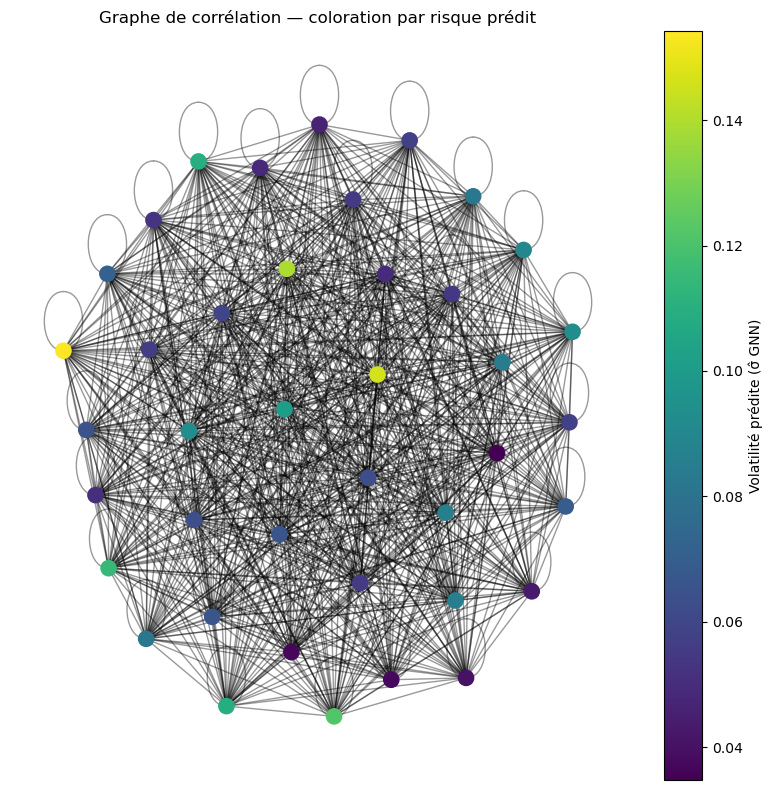

In [115]:


plt.figure(figsize=(8, 8))

# Layout du graphe
pos = nx.spring_layout(G_sub, seed=42)

# Couleurs des noeuds (σ̂)
node_colors = [sigma_sub[n] for n in G_sub.nodes()]

nodes = nx.draw_networkx_nodes(
    G_sub,
    pos,
    node_color=node_colors,
    cmap="viridis",
    node_size=120,
)

nx.draw_networkx_edges(
    G_sub,
    pos,
    alpha=0.4,
    width=1,
)

plt.colorbar(nodes, label="Volatilité prédite (σ̂ GNN)")
plt.title("Graphe de corrélation — coloration par risque prédit")
plt.axis("off")
plt.tight_layout()
plt.show()

Ce graphique représente un sous-graphe des actifs les plus connectés dans le graphe de corrélation, où chaque nœud correspond à un actif et chaque arête à une dépendance entre deux actifs. La couleur des nœuds indique la volatilité prédite par le GNN (\(\hat{\sigma}\)).

**Organisation du risque dans le graphe.**  
On observe que les niveaux de risque prédits ne sont pas distribués aléatoirement parmi les actifs. Certains groupes de nœuds fortement connectés présentent des niveaux de volatilité similaires, suggérant une structuration du risque à travers les relations inter-actifs.

**Apport spécifique du GNN.**  
Cette visualisation illustre l’intérêt d’un modèle basé sur les graphes : la prédiction du risque pour un actif est influencée par son voisinage dans le réseau. Le GNN est ainsi capable de capturer des mécanismes de propagation du risque, impossibles à modéliser avec des approches indépendantes par actif.

**Lien avec la gestion du risque.**  
En exploitant cette structure, le modèle fournit un signal de risque global cohérent, qui peut être utilisé pour ajuster l’exposition du portefeuille de manière préventive, en tenant compte non seulement du risque individuel mais aussi du risque systémique porté par le réseau.